In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats

import sys
sys.path.append("../")

import utils_ML as uml

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
nsaf = pd.read_hdf("../../Atlas_creation/proteome_nsaf_pooled_3.h5")
nsaf = nsaf.pivot(index = "assay_id", columns = "uniprot_id", values = "NSAF")

meta = pd.read_csv("../../Metadata/unified_metadata.csv", index_col="assay_id")
meta = meta[meta.index.isin(nsaf.index)]

nsaf.sort_index(inplace=True)
meta.sort_index(inplace=True)

In [3]:
def calc_median(row):
    values = row[row!=0]
    return np.median(values)

def get_fc_plot(sample1, sample2, index):
    '''returns list of fold changes of protein abundance between the 2 samples'''
    log_fc = []

    count = 0
    for i in range(len(sample1)):
        if sample1[i] != 0.0 and sample2[i] != 0.0:
            log_fc.append(sample1[i] / sample2[i])
            count += 1
    
    print(f"{index}:\tcommon prots: {count}\tmedianFC: {np.median(log_fc)}\tstdFC: {np.std(log_fc)}")
    return log_fc

def plot_fc(subset, ref = None, plot_med_fc = False, color_scheme = None, xlims = (-2,2)):
    """ref = index of the reference sample, default is first sample"""
    full_df = pd.DataFrame(data = {"fold_change":{}, "index":{}})
    if ref == None:
        ref = subset.loc[subset.index[0],:]
        ref_i = ref.name
    else:
        ref = subset.loc[ref,:]
        ref_i = ref.name

    list_med_fc = []
    indices = []
    for index, row in subset.iterrows():
        if index == ref_i:
            continue
        
        fc_list = get_fc_plot(ref, row, index)
        list_med_fc.append(np.median(fc_list))
        indices.append(index)
        df = pd.DataFrame({"fold_change": fc_list})
       
        df["index"] = index
        full_df = pd.concat([full_df, df], ignore_index = True)

    if plot_med_fc:
        fig, (ax1, ax2) = plt.subplots(1,2,figsize = (25,8))
        
        ax1.set_xlim(right= xlims[1], left = xlims[0])    
        ax1.set_title("Fold changes")
        ax2.set_title("median fold changes")
        if color_scheme != None:
            sns.kdeplot(data=full_df, x = "fold_change", hue = "index", palette = color_scheme, common_norm = False, alpha = .8, ax = ax1, legend = False)
            sns.barplot(x = indices, y = list_med_fc, ax = ax2, palette = color_scheme,  alpha = .8)
        
        else:
            sns.kdeplot(data=full_df, x = "fold_change", hue = "index", palette = "tab10", common_norm = False, alpha = .8, ax = ax1, legend = False)
            sns.barplot(x = indices, y = list_med_fc, ax = ax2, palette = "tab10",  alpha = .8)
        return
        
    plt.xlim(right= 2, left = -2)    
    sns.kdeplot(data=full_df, x = "fold_change", hue = "index", palette = "tab10", common_norm = False, alpha = .5, legend = False)

def calculate_correlations(dataset, assay_ids):
    
    correlation_assays = {pxd :[] for pxd in meta.loc[assay_ids].PXD_accession.unique()}
    across_project_corr = {}
    dataset = dataset
    
    comparisons = combinations(assay_ids, 2)

    for comparison in comparisons:
        id1 = comparison[0]
        id2 = comparison[1]

        comp_df = dataset.loc[[id1,id2], :].T.dropna()

        r = stats.pearsonr(x=comp_df.loc[:,id1], y=comp_df.loc[:,id2])[0]

        pxd1 = meta.loc[id1].PXD_accession
        pxd2 = meta.loc[id2].PXD_accession
        if pxd1 == pxd2:
            correlation_assays[meta.loc[id1].PXD_accession].append(r)
        
        elif str(pxd1)+"-"+str(pxd2) in across_project_corr.keys():
            across_project_corr[str(pxd1)+"-"+str(pxd2)].append(r)

        elif str(pxd2)+"-"+str(pxd1) in across_project_corr.keys():
            across_project_corr[str(pxd2)+"-"+str(pxd1)].append(r)
        else:
            across_project_corr[str(pxd1)+"-"+str(pxd2)] = [r]

    return correlation_assays, across_project_corr


def calculate_correlations_bygroup(scaled_dataset):

    groups = meta.Group.unique()

    within_corr_g = []
    between_corr_g = []
    within_corr_sca_g = []
    between_corr_sca_g = []

    for group in groups:

        within_corr, between_corr = calculate_correlations(np.log2(nsaf_filtered), meta[meta.Group == group].index)
        within_corr_sca, between_corr_sca = calculate_correlations(scaled_dataset, meta[meta.Group == group].index)

        all_within_corr = []
        for px, x in within_corr.items():
            all_within_corr+=x
            #print(px, np.mean(x))

        all_between_corr = []
        for x in between_corr.values():
            all_between_corr += x

        all_within_corr_sca = []
        for px, x in within_corr_sca.items():
            all_within_corr_sca+=x
            #print(px, np.mean(x))

        all_between_corr_sca = []
        for x in between_corr_sca.values():
            all_between_corr_sca += x

        within_corr_g.append(all_within_corr)
        between_corr_g.append(all_between_corr)
        within_corr_sca_g.append(all_within_corr_sca)
        between_corr_sca_g.append(all_between_corr_sca)

    fig, ax = plt.subplots(2,1, figsize=(30,12))

    ax[0].set_title("Correlations project")
    ax[0].set_ylim((0,1))
    ax[1].set_title("Correlations project (scaled)")
    ax[1].set_ylim((0,1))

    dfs = []
    dfs_sca = []

    for i, g in enumerate(groups):

        all_within = pd.DataFrame(data=within_corr_g[i])
        all_within["Type"] = "Within project"
        all_between = pd.DataFrame(data=between_corr_g[i])
        all_between["Type"] = "Between projects"
        corr_df = pd.concat([all_within,all_between])
        corr_df["Group"] = g
        dfs.append(corr_df)

        all_within_sca = pd.DataFrame(data=within_corr_sca_g[i])
        all_within_sca["Type"] = "Within project"
        all_between_sca = pd.DataFrame(data=between_corr_sca_g[i])
        all_between_sca["Type"] = "Between projects"
        corr_df_sca = pd.concat([all_within_sca,all_between_sca])
        corr_df_sca["Group"] = g
        dfs_sca.append(corr_df_sca)
    
    corr_df_g = pd.concat(dfs)
    corr_df_sca_g = pd.concat(dfs_sca)

    sns.boxplot(data=corr_df_g,x="Group", y=0, hue="Type", ax=ax[0])
    sns.boxplot(data=corr_df_sca_g,x="Group", y=0, hue="Type", ax=ax[1])

    return corr_df_g, corr_df_sca

In [4]:
groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])

IndexError: index 0 is out of bounds for axis 0 with size 0

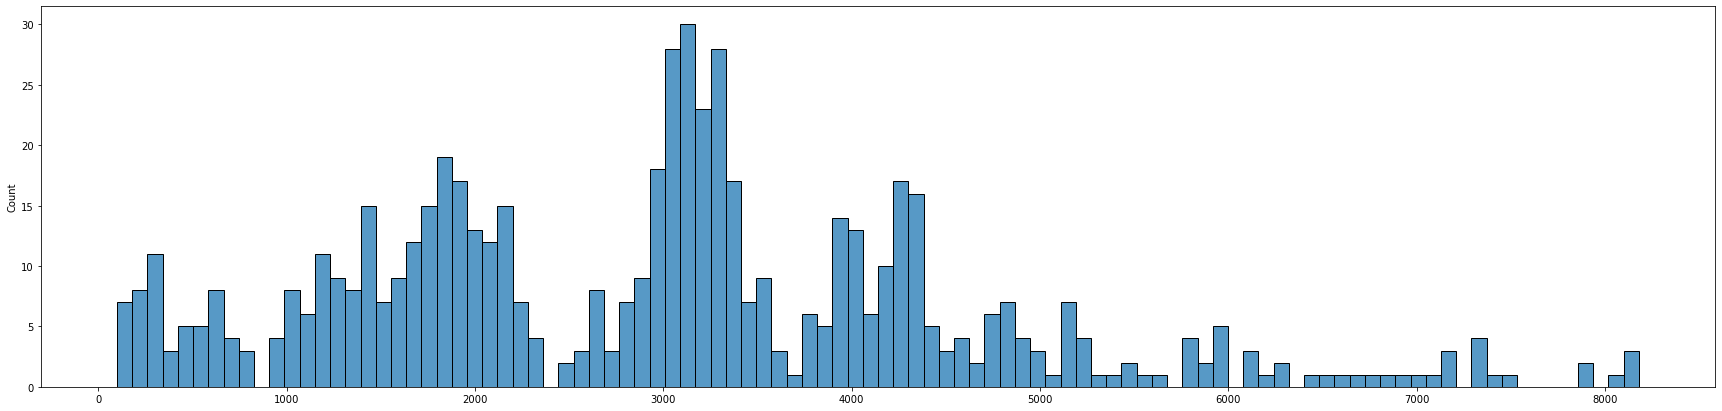

In [6]:
plt.figure(figsize=(30,7))
sns.histplot(nsaf.notna().sum(axis = 1), bins = 100)

In [10]:
# percentage missing values
nsaf.isna().sum().sum()/ (nsaf.shape[0]*nsaf.shape[1])

0.7948205802584948

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


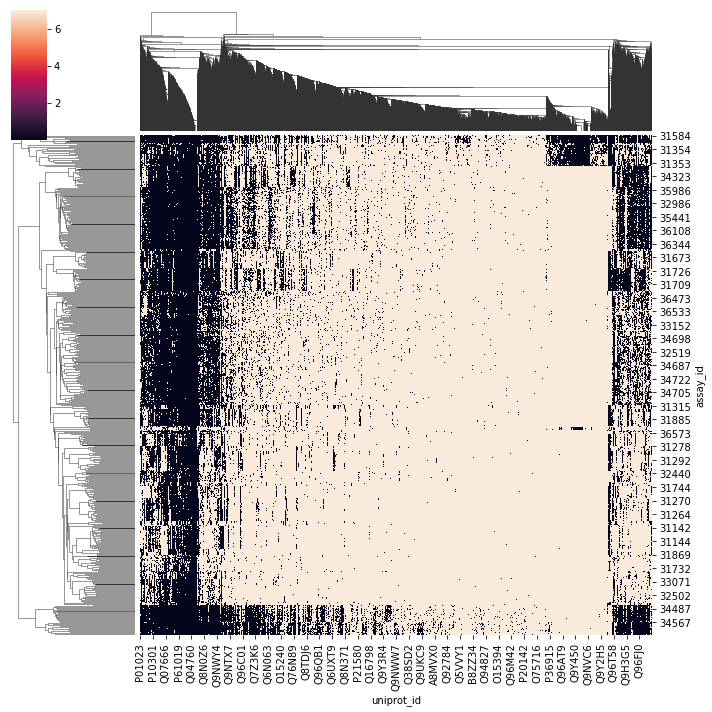

In [269]:
plt.figure(figsize=(10,10))
sns.clustermap(nsaf.fillna(7))

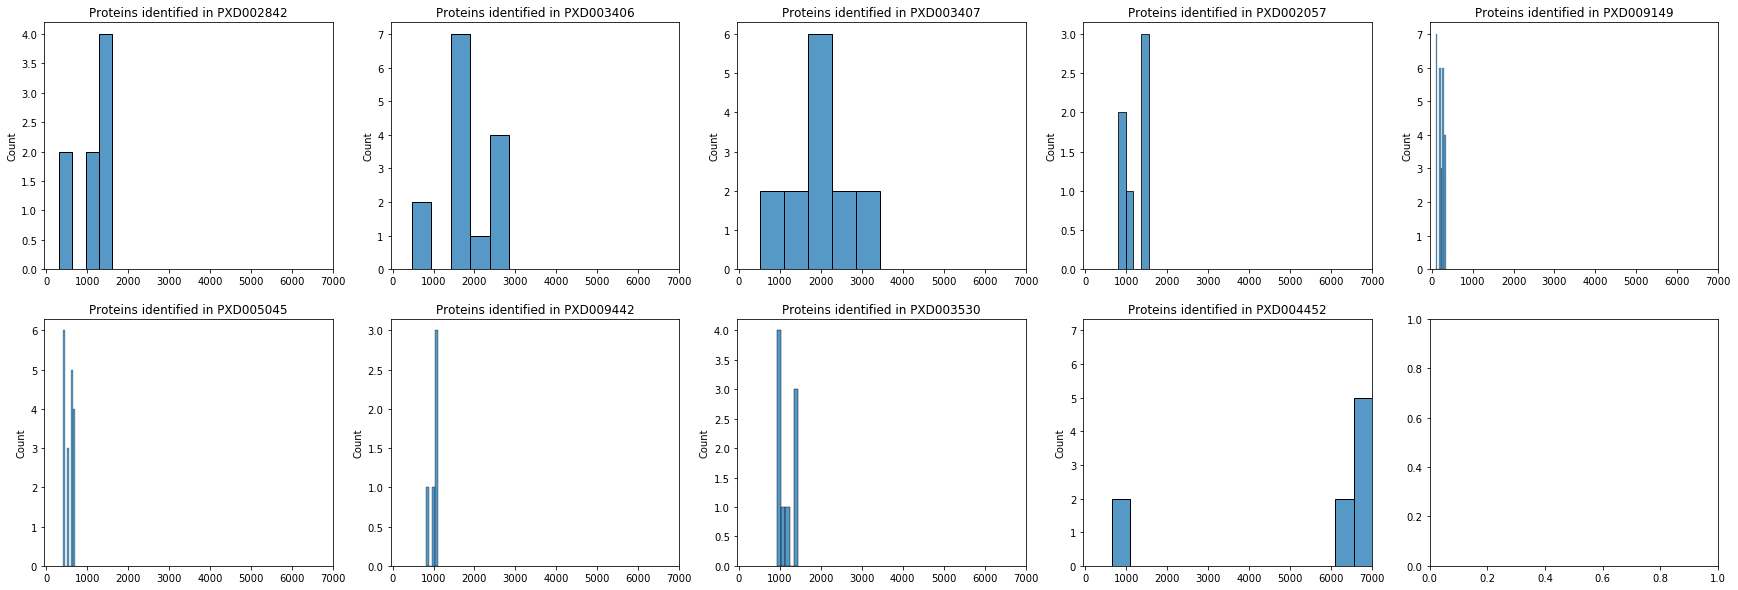

In [7]:
fig, ax = plt.subplots(2,5, figsize= (30,10))
for y, pxd in enumerate(meta.loc[nsaf.index[nsaf.notna().sum(axis=1) <1000], :].PXD_accession.unique()):
    
    if y < 5: 
        x=0
    else:
        y-=5
        x=1
    ax[x,y].set_title(f"Proteins identified in {pxd}")
    ax[x,y].set_xlim(left=-50, right=7000)
    sns.histplot(nsaf.loc[meta.PXD_accession == pxd].notna().sum(axis=1), ax=ax[x,y])

- **PXD002842**: Reported 3721 protein identifications. Here, only 312-1612 protein identifications were found with ionbot_v0.6.2 from 152,961 - 227,169 PSMs (sign_PSM: 31800). Drop the ones <1100
- **PXD003406, PXD003407**: Reported 8370 protein identifications. Here 4800 unique protein identifications were done. Assays reporting < 1100 proteins are dropped. Mean PSMs: 120,000 (sign_PSM: 21000). (ionbot_v0.6.2)
- **PXD002057**: Reported 800 protein identifications. Drop the AZD8931 resistant SKBR3 cells which all have <1100 protein identifications. sign_PSMs: 7500-9000. ionbot_version: v0.8.0
- **PXD009149**: Reported 3377 shared proteins (75% of total --> 4502 total proteins). ionbot_V0.6.0.2 never reaches more than 400 proteins with average sign_PSM: 843. Drop all of them
- **PXD005045**: Reported 1557 total protein identifications. We identify 1352 with ionbotv0.6.2. Average PSM (48398) with avg sign_PSM: 7897. No sample identified >700 proteins. Drop all of them.
- **PXD009442**: Reported +-2000 protein identifications per sample, however, only 1 proteotypic peptide was used to identify a protein. Here, >2 are needed and resulted in +- 1000 protein identifications per sample. Avg sign_PSM: 13311 (ionbotV0.6.2). Only keep the untreated cell. (assay_id 31702 with 1119 protein identifications)
- **PXD003530**: From 190,000-77,000 PSMs, (30,000-15,000 sign_PSM), only 950-1500 proteins were identified were >800 were identified in all samples. Keep only the ones with >1100 identifications.
- **PXD004452**: Only 2 assays identified <1100 proteins. For these, fractions are probably missing as most other identified >6000 proteins. Drop them.

In [4]:
low_id_rate = nsaf.loc[meta[meta.PXD_accession.isin("PXD002842 PXD003407 PXD003406 PXD002057 PXD009149 PXD005045 PXD009442 PXD003530 PXD004452".split())].index,:].notna().sum(axis=1)
drop_assays = low_id_rate.index[low_id_rate < 1100]
nsaf_filtered = nsaf.loc[~nsaf.index.isin(drop_assays)]

meta_filtered = meta[meta.index.isin(nsaf_filtered.index)]
print(meta_filtered.PXD_accession.nunique(), "projects and", meta_filtered.shape[0], "proteomes")
meta = meta_filtered.reset_index()
groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])
meta = meta.set_index("assay_id")
meta.sort_index(inplace=True)

44 projects and 557 proteomes


<Figure size 720x720 with 0 Axes>

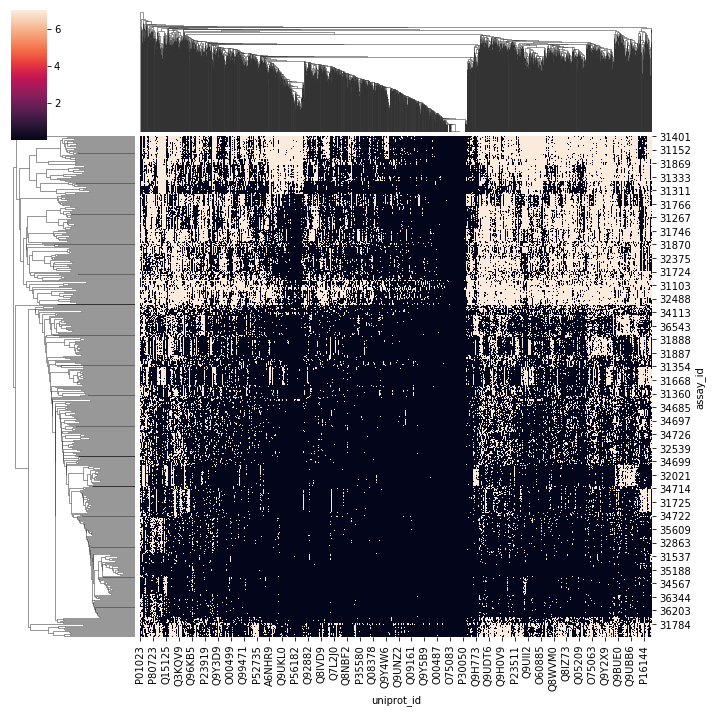

In [270]:
plt.figure(figsize=(10,10))
sns.clustermap(nsaf_filtered.fillna(7))

In [22]:
# percentage missing values
nsaf_filtered.isna().sum().sum()/ (nsaf_filtered.shape[0]*nsaf_filtered.shape[1])

0.775211595368001

In [5]:
cell_tissue_map = {"cell_line":[], "tissue_type":[]}

for i, row in meta.loc[:,["cell_line", "tissue_type"]].iterrows():
    cell, tissue = row
    if cell not in cell_tissue_map["cell_line"]:
        cell_tissue_map["cell_line"].append(cell)
        cell_tissue_map["tissue_type"].append(tissue)
cell_tissue_map = pd.DataFrame(cell_tissue_map)

In [6]:
lut = {}
colors = sns.color_palette("deep") + sns.color_palette("bright")
for x in meta.tissue_type.unique():
    lut[x] = colors[len(lut)]

In [39]:
len(lut)

16

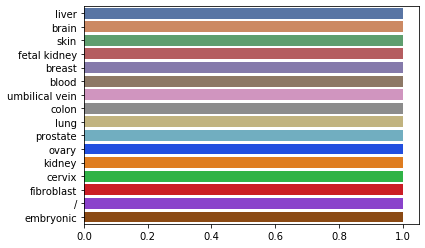

In [41]:
sns.barplot(x=[1]*16, y= list(lut.keys()), palette=list(lut.values()))

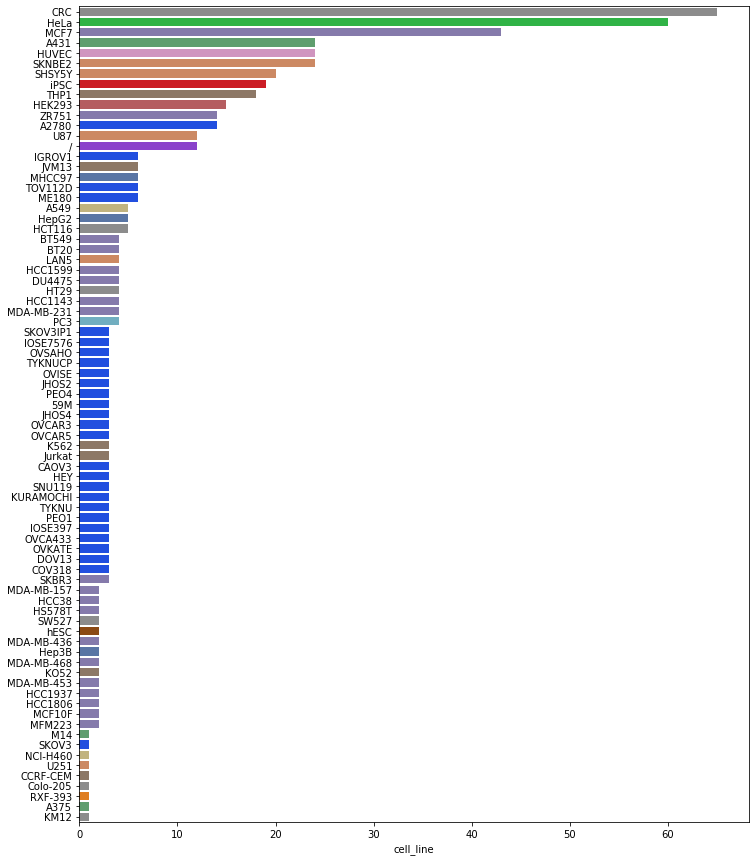

In [42]:
fig, ax = plt.subplots(1,1,figsize=(12,15))
sns.barplot(x=meta[meta.index.isin(nsaf_filtered.index)].cell_line.value_counts(), y = meta[meta.index.isin(nsaf_filtered.index)].cell_line.value_counts().index, palette=cols)

In [7]:
# Only select groups with >= 10 samples
apc = meta.Group.value_counts(sort = True)
apc=apc[apc>=10]

meta = meta[meta.Group.isin(apc.index)]
nsaf = nsaf[nsaf.index.isin(meta.index)]

meta.sort_index(inplace=True)
nsaf.sort_index(inplace=True)

print(meta.shape, nsaf.shape)

(518, 20) (518, 14507)


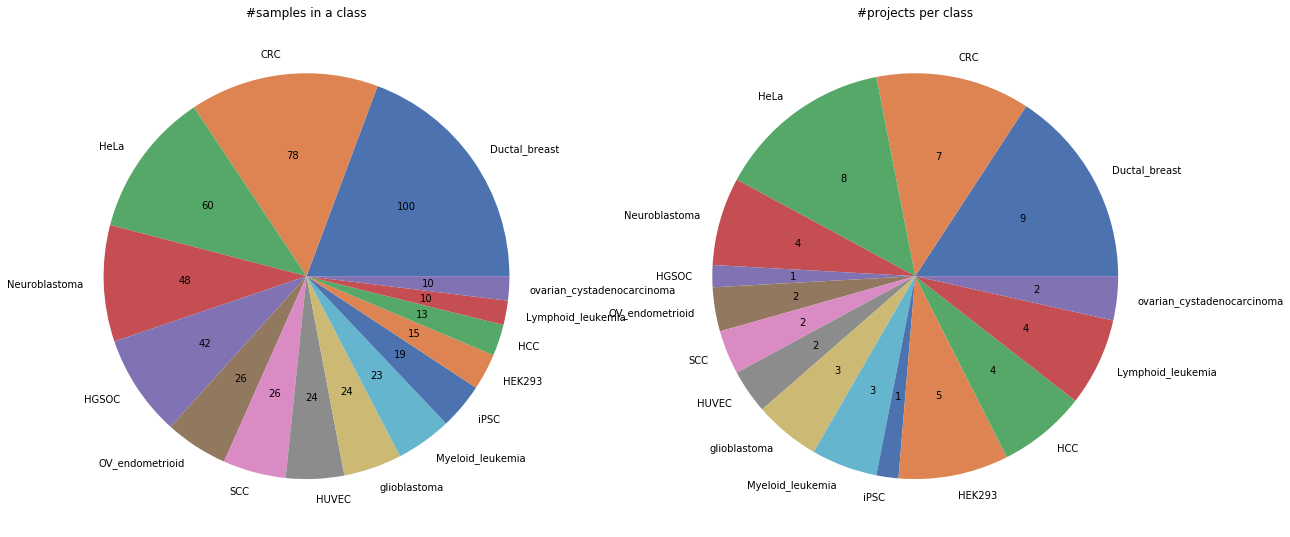

In [11]:
apc = meta.Group.value_counts(sort = True)
label_order = apc.index
ppc = meta.groupby("Group", sort = False).nunique().PXD_accession[label_order]

fig = plt.figure(figsize=(20,10))
fig.set_facecolor("white")

plt.subplot(121)
plt.title("#samples in a class")
_ = plt.pie(apc.values, labels = label_order.values, colors = sns.color_palette("deep"),
autopct= lambda p: '{:.0f}'.format(p*sum(apc.values)/100))

plt.subplot(122)
plt.title(r"#projects per class")
_ = plt.pie(ppc.values, labels = label_order.values, colors = sns.color_palette("deep"),
autopct = lambda p: '{:.0f}'.format(p*sum(ppc.values)/100))

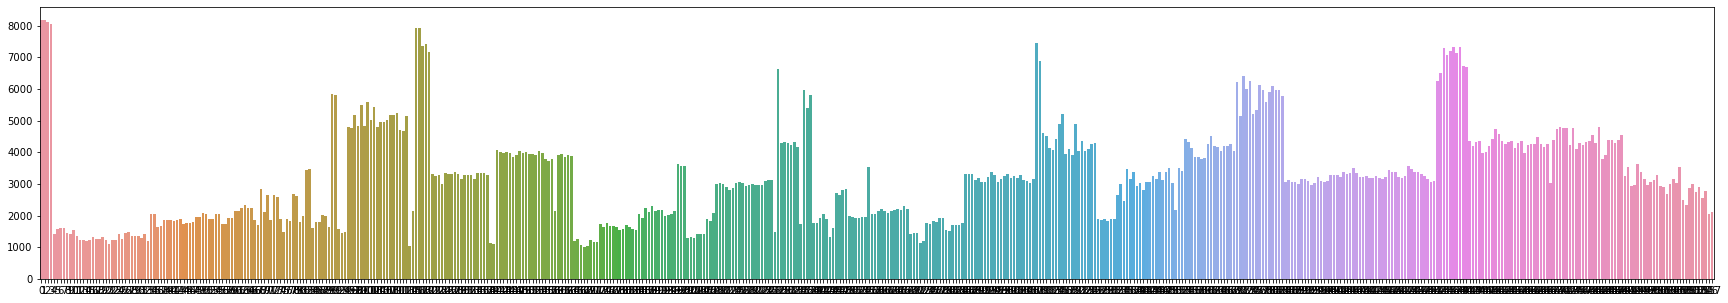

In [46]:
# Protein identification landscape
plt.figure(figsize=(30,5))
sns.barplot(x=list(range(len(nsaf))), y=nsaf.notna().sum(axis=1))

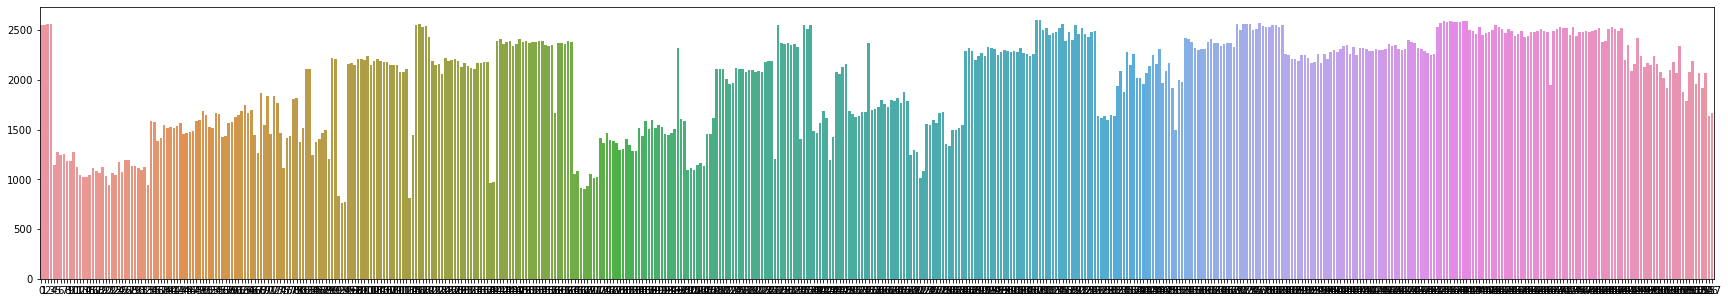

In [8]:
nsaf_filtered = uml.FilterByOccurence(.5).fit_transform(nsaf)

plt.figure(figsize=(30,5))
sns.barplot(x=list(range(len(nsaf_filtered))), y=nsaf_filtered.notna().sum(axis=1))

<Figure size 720x720 with 0 Axes>

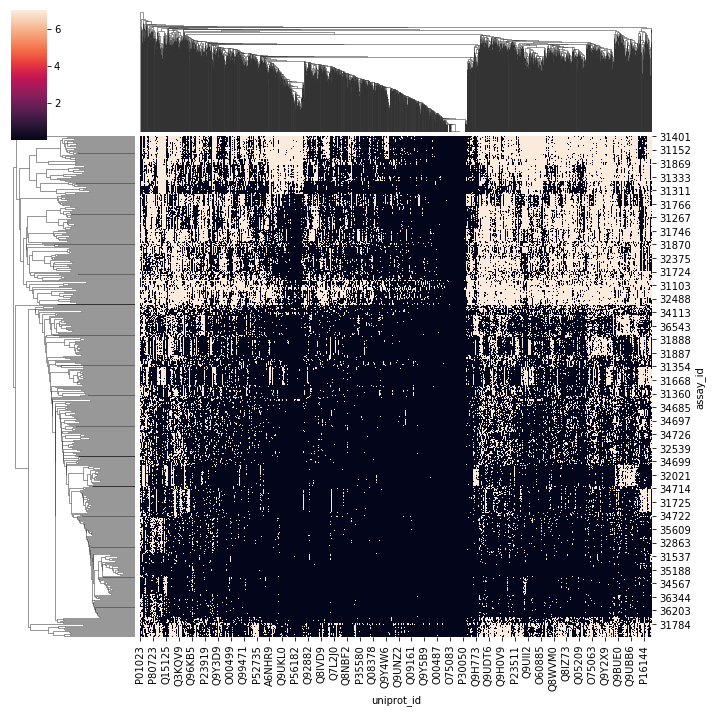

In [271]:
plt.figure(figsize=(10,10))
sns.clustermap(nsaf_filtered.fillna(7))

In [48]:
# percentage missing values
nsaf_filtered.isna().sum().sum()/ (nsaf_filtered.shape[0]*nsaf_filtered.shape[1])

0.24054054054054055

In [53]:
print(nsaf_filtered.shape)

(518, 2615)


In [9]:
filtered_90 = uml.FilterByOccurence(.9).fit_transform(nsaf_filtered)

In [54]:
print(filtered_90.shape)

(518, 636)


In [ ]:
palette=meta.iloc[:200,:].PXD_accession.apply(lambda x: mapper[x]).values

In [10]:
mapper = zip(meta.PXD_accession.unique(), sns.color_palette("pastel", n_colors=meta.PXD_accession.nunique()))
mapper = dict(mapper)

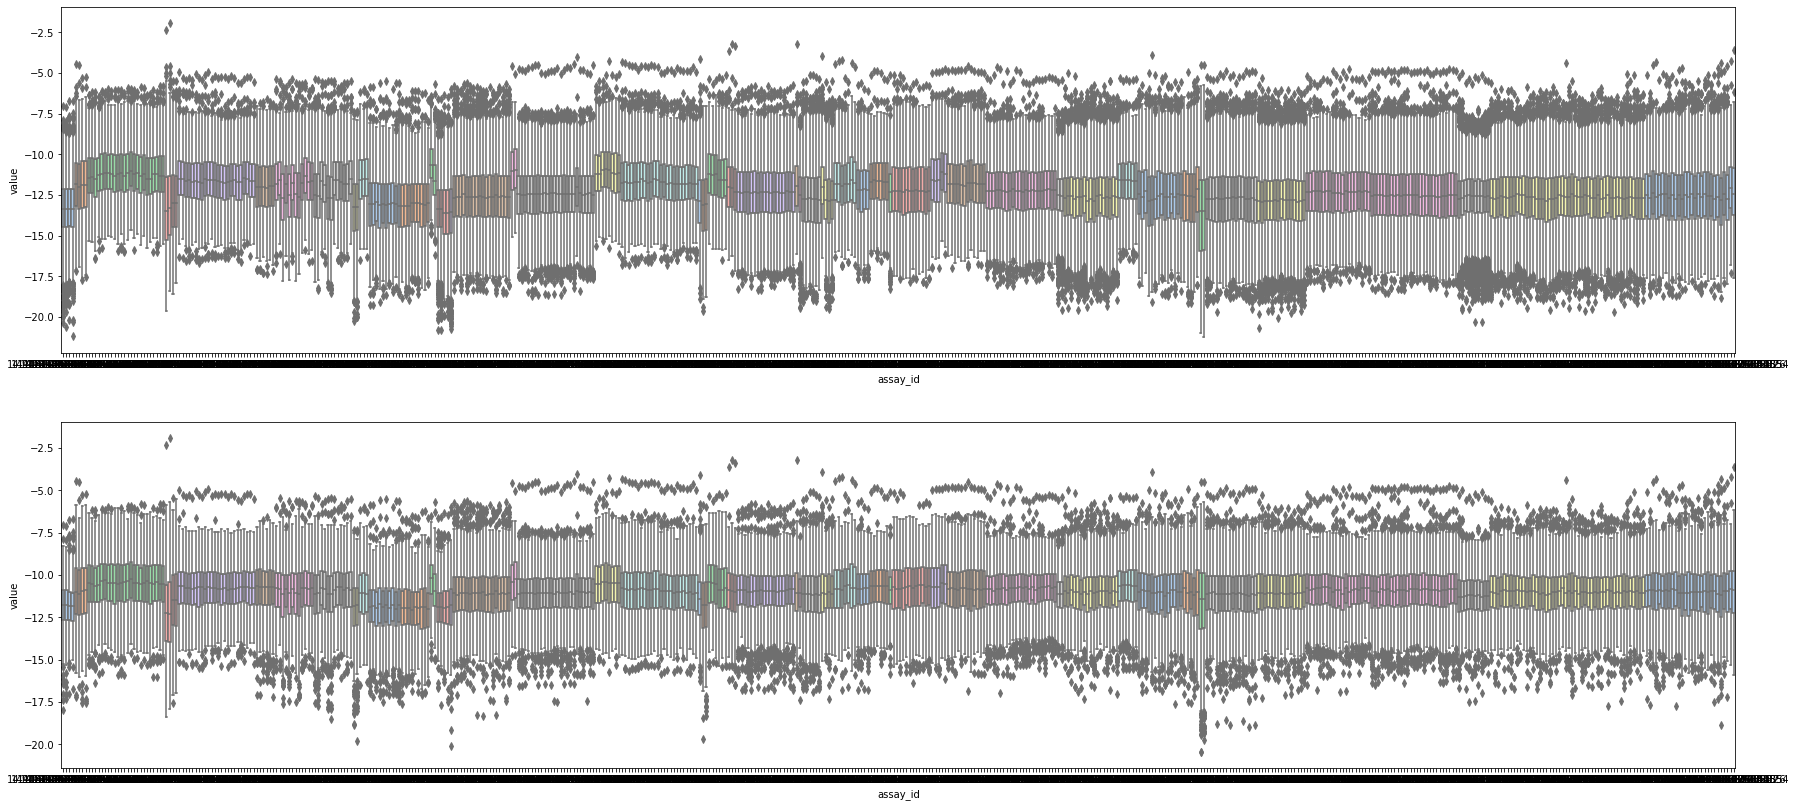

In [52]:
fig, ax = plt.subplots(2,1,figsize=(30,14))

sns.boxplot(data=np.log2(nsaf_filtered.T.melt().dropna()), y='value', x="assay_id", ax=ax[0], palette=meta.PXD_accession.apply(lambda x: mapper[x]).values)

sns.boxplot(data=np.log2(filtered_90.T.melt().dropna()), y='value', x="assay_id", ax=ax[1], palette=meta.PXD_accession.apply(lambda x: mapper[x]).values)

In [124]:
fig, ax = plt.subplots(1,2,figsize=(30,7))
sns.scatterplot(np.log2(nsaf_filtered).median(axis=1), nsaf_filtered.notna().sum(axis=1), ax=ax[0])
sns.scatterplot(np.log2(nsaf_filtered).loc[:, filtered_90.columns].median(axis=1), nsaf_filtered.notna().sum(axis=1), ax=ax[1])

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


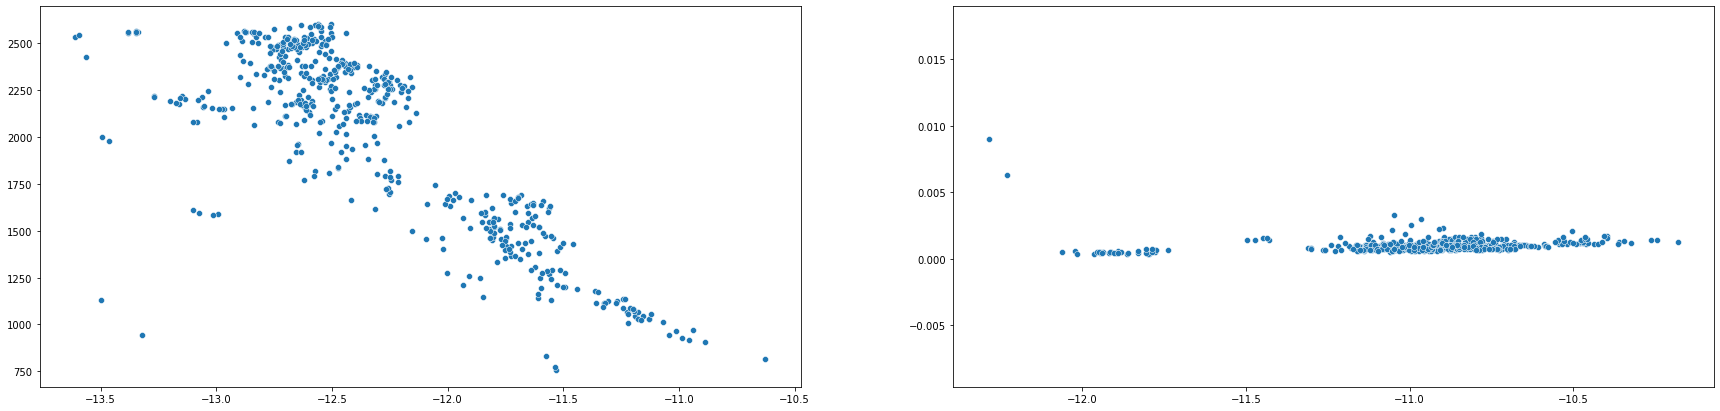

In [16]:
fig, ax = plt.subplots(1,2,figsize=(30,7))
sns.scatterplot(np.log2(nsaf_filtered).median(axis=1), nsaf_filtered.notna().sum(axis=1), ax=ax[0])
sns.scatterplot(np.log2(nsaf_filtered).loc[:, filtered_90.columns].median(axis=1), nsaf_filtered.std(axis=1), ax=ax[1])

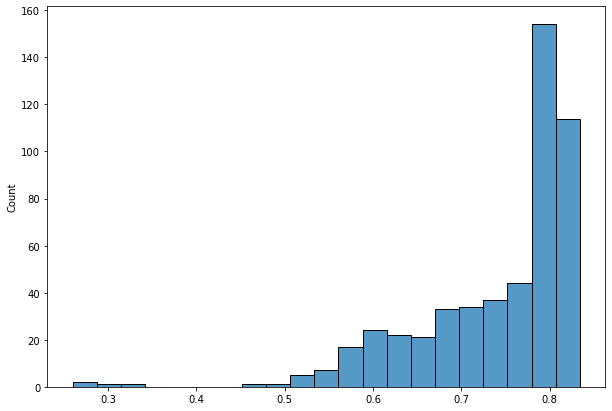

In [55]:
ranked_df = nsaf_filtered.fillna(100).rank(axis=1, method="min").multiply(1/nsaf_filtered.notna().sum(axis=1), axis="index")
ranked_df = ranked_df.applymap(lambda x: 0 if x>1 else x)

# Most of the selected proteins are the most abundant ones in the sample
plt.figure(figsize=(10,7))
sns.histplot(ranked_df.loc[:,filtered_90.columns].median(axis=1))

In [59]:
print(ranked_df.index[ranked_df.loc[:,filtered_90.columns].median(axis=1)<.4])
meta[ranked_df.loc[:,filtered_90.columns].median(axis=1)<.4]

Int64Index([31345, 31347, 31349, 31376], dtype='int64', name='assay_id')


project_id                   filename  cell_id cell_line  \
assay_id                                                             
31345           1826     130327_o2_02_hu_P1_2hr      562     SKBR3   
31347           1826     130327_o2_04_hu_P2_2hr      562     SKBR3   
31349           1826     130327_o2_06_hu_P3_2hr      562     SKBR3   
31376           1829  160116_K052_OffLRP_RP_f02      569      KO52   

                   disease treatment tissue_type sub_cell  organ_id  \
assay_id                                                              
31345       adenocarcinoma         /      breast        /       NaN   
31347       adenocarcinoma         /      breast        /       NaN   
31349       adenocarcinoma         /      breast        /       NaN   
31376     myeloid leukemia         /       blood        /       NaN   

         PXD_accession  all_PSM  sign_PSM  peptides  proteins experiment_type  \
assay_id                                                                        
31345        PXD002057     9453      8718      7501      1593     in-solution   
31347        PXD002057     8124      7517      6444      1464     in-solution   
31349        PXD002057     8309      7697      6630      1502     in-solution   
31376        PXD008381    23390       448       172       131     in-solution   

                   instrument      pmid  pool_id ionbot_version  \
assay_id                                                          
31345              Q-exactive  26883193        0  IONBOT_v0.8.0   
31347              Q-exactive  26883193        0  IONBOT_v0.8.0   
31349              Q-exactive  26883193        0  IONBOT_v0.8.0   
31376     Orbitrap Fusion ETD  30295032        1  IONBOT_v0.6.2   

                     Group  
assay_id                    
31345        Ductal_breast  
31347        Ductal_breast  
31349        Ductal_breast  
31376     Myeloid_leukemia

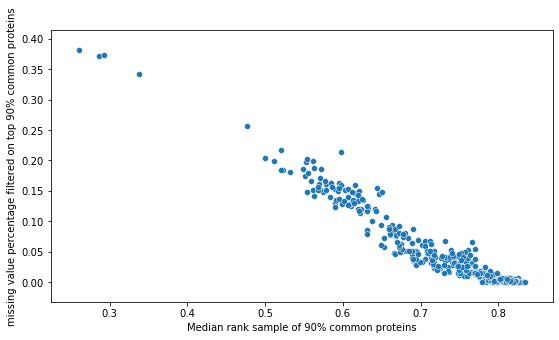

In [64]:
# Apart from some outliers, the most detected proteins are the most abundant ones
plt.figure(figsize=(9,5))
plt.xlabel("Median rank sample of 90% common proteins")
plt.ylabel("missing value percentage filtered on top 90% common proteins")
sns.scatterplot(x=ranked_df.loc[:,filtered_90.columns].median(axis=1), y=filtered_90.isna().sum(axis=1)/ filtered_90.shape[1])

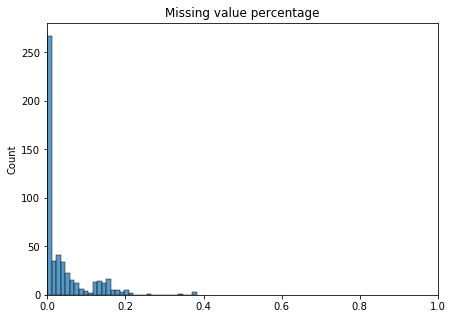

In [61]:
plt.figure(figsize=(7,5))
plt.title("Missing value percentage")
plt.xlim((0,1))
sns.histplot(filtered_90.isna().sum(axis=1)/ filtered_90.shape[1])

In [11]:
med_std = pd.DataFrame(index=nsaf_filtered.index)
med_std["med"] = np.log2(filtered_90).median(axis=1)
med_std["std_"] = np.log2(filtered_90).std(axis=1)
scaled_nsaf = {}
for i, row in np.log2(nsaf_filtered).iterrows():
    scaled_nsaf[i] = (np.array(row) - med_std.loc[i,"med"]) / med_std.loc[i,"std_"]

scaled_nsaf = pd.DataFrame(scaled_nsaf, index=nsaf_filtered.columns).T

In [110]:
fig, ax = plt.subplots(2,1,figsize=(30,14))
sns.boxplot(data=scaled_nsaf.T.melt().dropna(), y='value', x="variable", ax=ax[0], palette=meta.PXD_accession.apply(lambda x: mapper[x]).values)
sns.boxplot(data=scaled_nsaf.loc[:, filtered_90.columns].T.melt().dropna(), y='value', x="variable", ax=ax[1], palette=meta.PXD_accession.apply(lambda x: mapper[x]).values)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


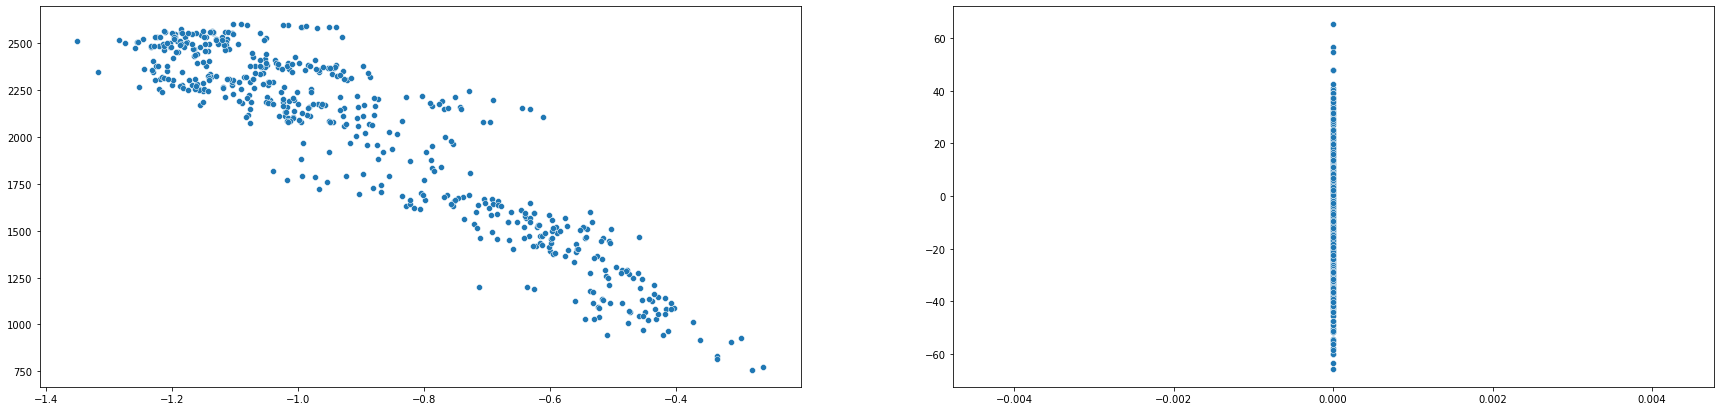

In [20]:
fig, ax = plt.subplots(1,2,figsize=(30,7))
sns.scatterplot(scaled_nsaf.median(axis=1), nsaf_filtered.notna().sum(axis=1), ax=ax[0])
sns.scatterplot(scaled_nsaf.loc[:, filtered_90.columns].median(axis=1), scaled_nsaf.loc[:, filtered_90.columns].sum(axis=1), ax=ax[1])

In [57]:
# Hela samples from different projects
nsaf_filtered.loc[[32003,32009,33066]].notna().sum(axis=1)

assay_id
32003    2368
32009    2365
33066    1637
dtype: int64

In [60]:
fig, ax = plt.subplots(1,2,figsize=(30,7))
sns.scatterplot(scaled_nsaf.loc[[32003,32009],:].mean(axis=0), scaled_nsaf.loc[32003,:].subtract(scaled_nsaf.loc[32009,:]), ax=ax[0])
sns.scatterplot(scaled_nsaf.loc[[32374,33066],:].mean(axis=0), scaled_nsaf.loc[32374,:].subtract(scaled_nsaf.loc[33066,:]), ax=ax[1])

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


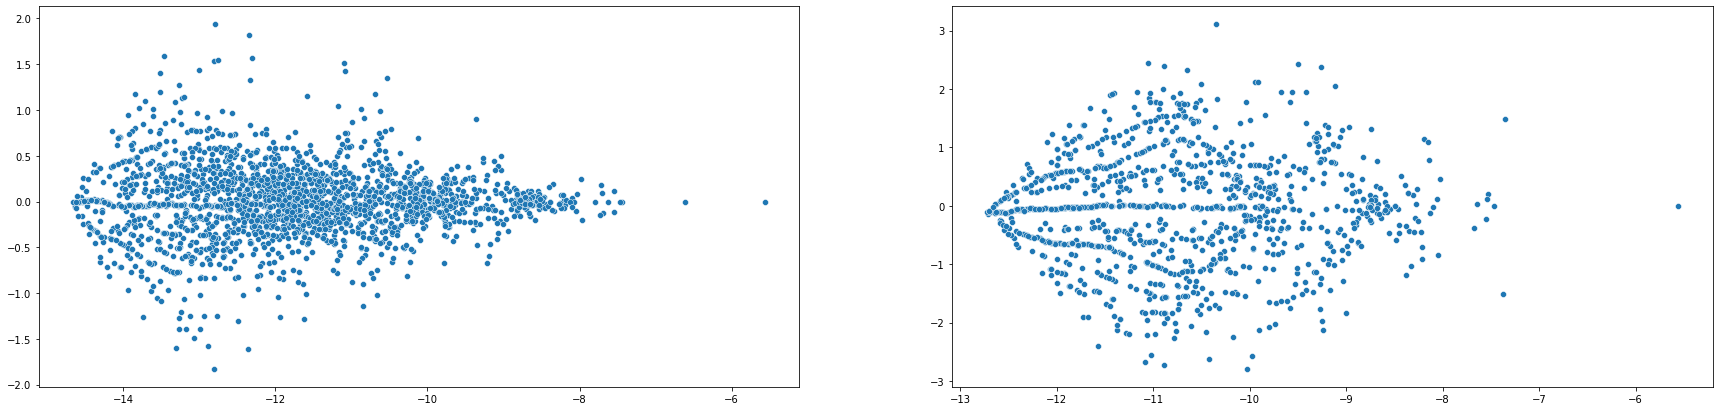

In [61]:
fig, ax = plt.subplots(1,2,figsize=(30,7))
sns.scatterplot(quantile_normalized_df.loc[[32003,32009],:].mean(axis=0), quantile_normalized_df.loc[32003,:].subtract(quantile_normalized_df.loc[32009,:]), ax=ax[0])
sns.scatterplot(quantile_normalized_df.loc[[32374,33066],:].mean(axis=0), quantile_normalized_df.loc[32374,:].subtract(quantile_normalized_df.loc[33066,:]), ax=ax[1])

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


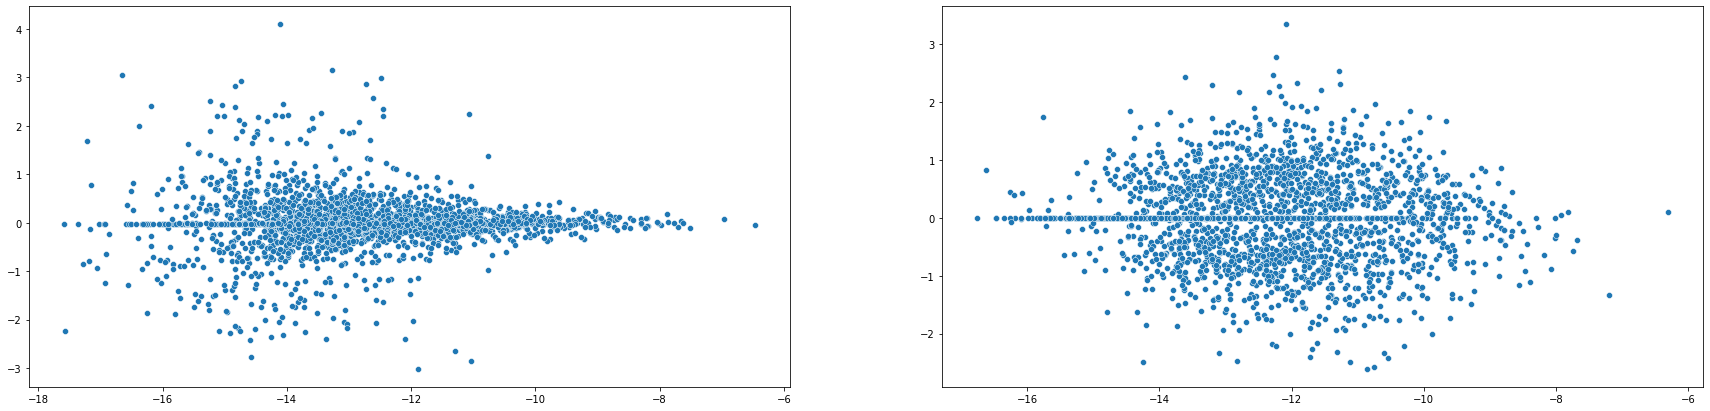

In [64]:
fig, ax = plt.subplots(1,2,figsize=(30,7))
sns.scatterplot(combat_df.loc[[32003,32009],:].mean(axis=0), combat_df.loc[32003,:].subtract(combat_df.loc[32009,:]), ax=ax[0])
sns.scatterplot(combat_df.loc[[32374,33066],:].mean(axis=0), combat_df.loc[32374,:].subtract(combat_df.loc[33066,:]), ax=ax[1])

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


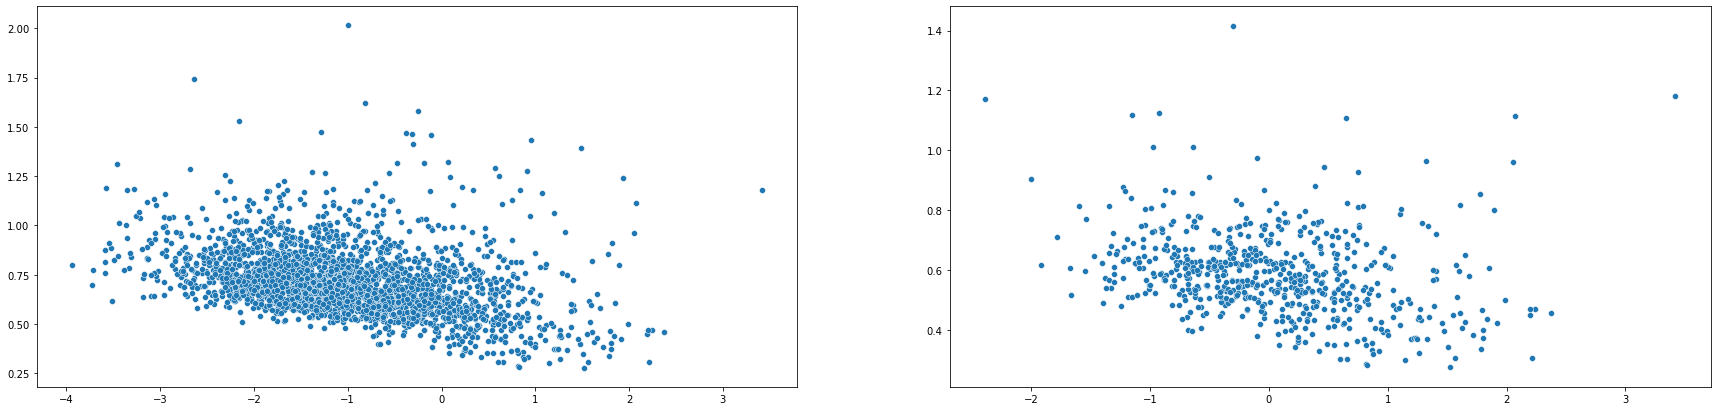

In [41]:
fig, ax = plt.subplots(1,2,figsize=(30,7))
sns.scatterplot(scaled_nsaf.median(axis=0), scaled_nsaf.std(axis=0), ax=ax[0])
sns.scatterplot(scaled_nsaf.loc[:, filtered_90.columns].median(axis=0), scaled_nsaf.loc[:, filtered_90.columns].std(axis=0), ax=ax[1])

In [80]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
scaler3 = MinMaxScaler()

minmax_scaled_quantile = scaler1.fit_transform(quantile_normalized_df)
minmax_scaled_quantile = pd.DataFrame(minmax_scaled_quantile, columns=quantile_normalized_df.columns, index= quantile_normalized_df.index)

minmax_scaled_med_norm = scaler2.fit_transform(scaled_nsaf)
minmax_scaled_med_norm = pd.DataFrame(minmax_scaled_med_norm, columns=scaled_nsaf.columns, index= scaled_nsaf.index)

minmax_combat = scaler3.fit_transform(combat_df)
minmax_combat = pd.DataFrame(minmax_combat, columns=combat_df.columns, index= combat_df.index)

scaler4 = StandardScaler()
scaler5 = StandardScaler()
scaler6 = StandardScaler()

std_scaled_quantile = scaler4.fit_transform(quantile_normalized_df)
std_scaled_quantile = pd.DataFrame(std_scaled_quantile, columns=quantile_normalized_df.columns, index= quantile_normalized_df.index)

std_scaled_med_norm = scaler5.fit_transform(scaled_nsaf)
std_scaled_med_norm = pd.DataFrame(std_scaled_med_norm, columns=scaled_nsaf.columns, index= scaled_nsaf.index)

std_combat = scaler6.fit_transform(combat_df)
std_combat = pd.DataFrame(std_combat, columns=combat_df.columns, index= combat_df.index)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in 

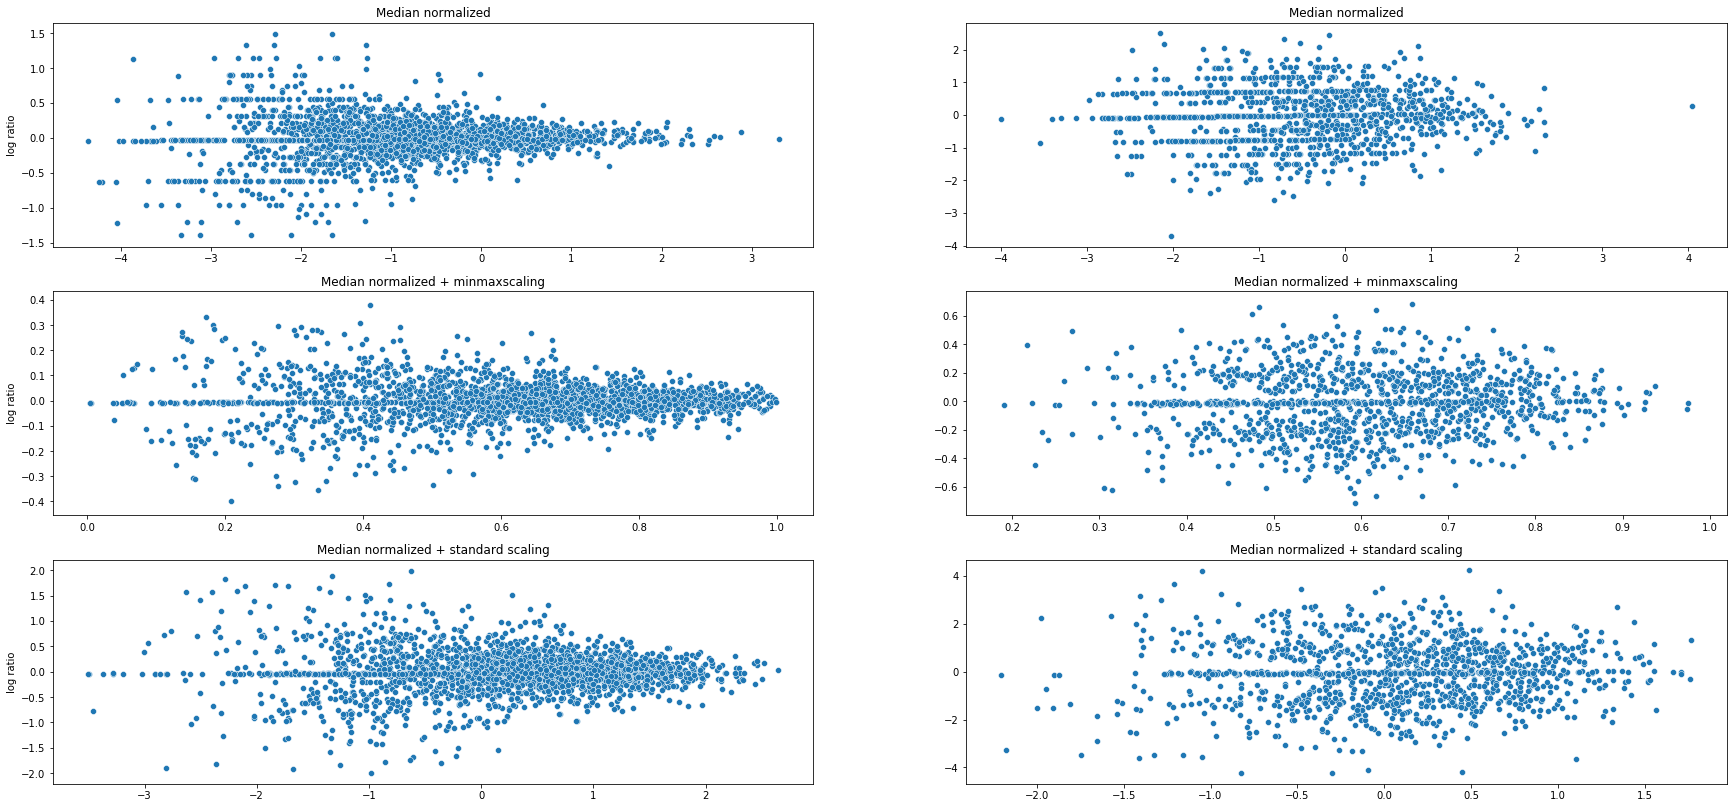

In [81]:
fig, ax = plt.subplots(3,2,figsize=(30,14))

ax[0][0].set_title("Median normalized")
ax[1][0].set_title("Median normalized + minmaxscaling")
ax[2][0].set_title("Median normalized + standard scaling")
ax[0][1].set_title("Median normalized")
ax[1][1].set_title("Median normalized + minmaxscaling")
ax[2][1].set_title("Median normalized + standard scaling")

ax[0][0].set_ylabel("log ratio")
ax[1][0].set_ylabel("log ratio")
ax[2][0].set_ylabel("log ratio")

sns.scatterplot(scaled_nsaf.loc[[32003,32009],:].mean(axis=0), scaled_nsaf.loc[32003,:].subtract(scaled_nsaf.loc[32009,:]), ax=ax[0][0])
sns.scatterplot(scaled_nsaf.loc[[32374,33066],:].mean(axis=0), scaled_nsaf.loc[32374,:].subtract(scaled_nsaf.loc[33066,:]), ax=ax[0][1])

sns.scatterplot(minmax_scaled_med_norm.loc[[32003,32009],:].mean(axis=0), minmax_scaled_med_norm.loc[32003,:].subtract(minmax_scaled_med_norm.loc[32009,:]), ax=ax[1][0])
sns.scatterplot(minmax_scaled_med_norm.loc[[32374,33066],:].mean(axis=0), minmax_scaled_med_norm.loc[32374,:].subtract(minmax_scaled_med_norm.loc[33066,:]), ax=ax[1][1])

sns.scatterplot(std_scaled_med_norm.loc[[32003,32009],:].mean(axis=0), std_scaled_med_norm.loc[32003,:].subtract(std_scaled_med_norm.loc[32009,:]), ax=ax[2][0])
sns.scatterplot(std_scaled_med_norm.loc[[32374,33066],:].mean(axis=0), std_scaled_med_norm.loc[32374,:].subtract(std_scaled_med_norm.loc[33066,:]), ax=ax[2][1])

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in 

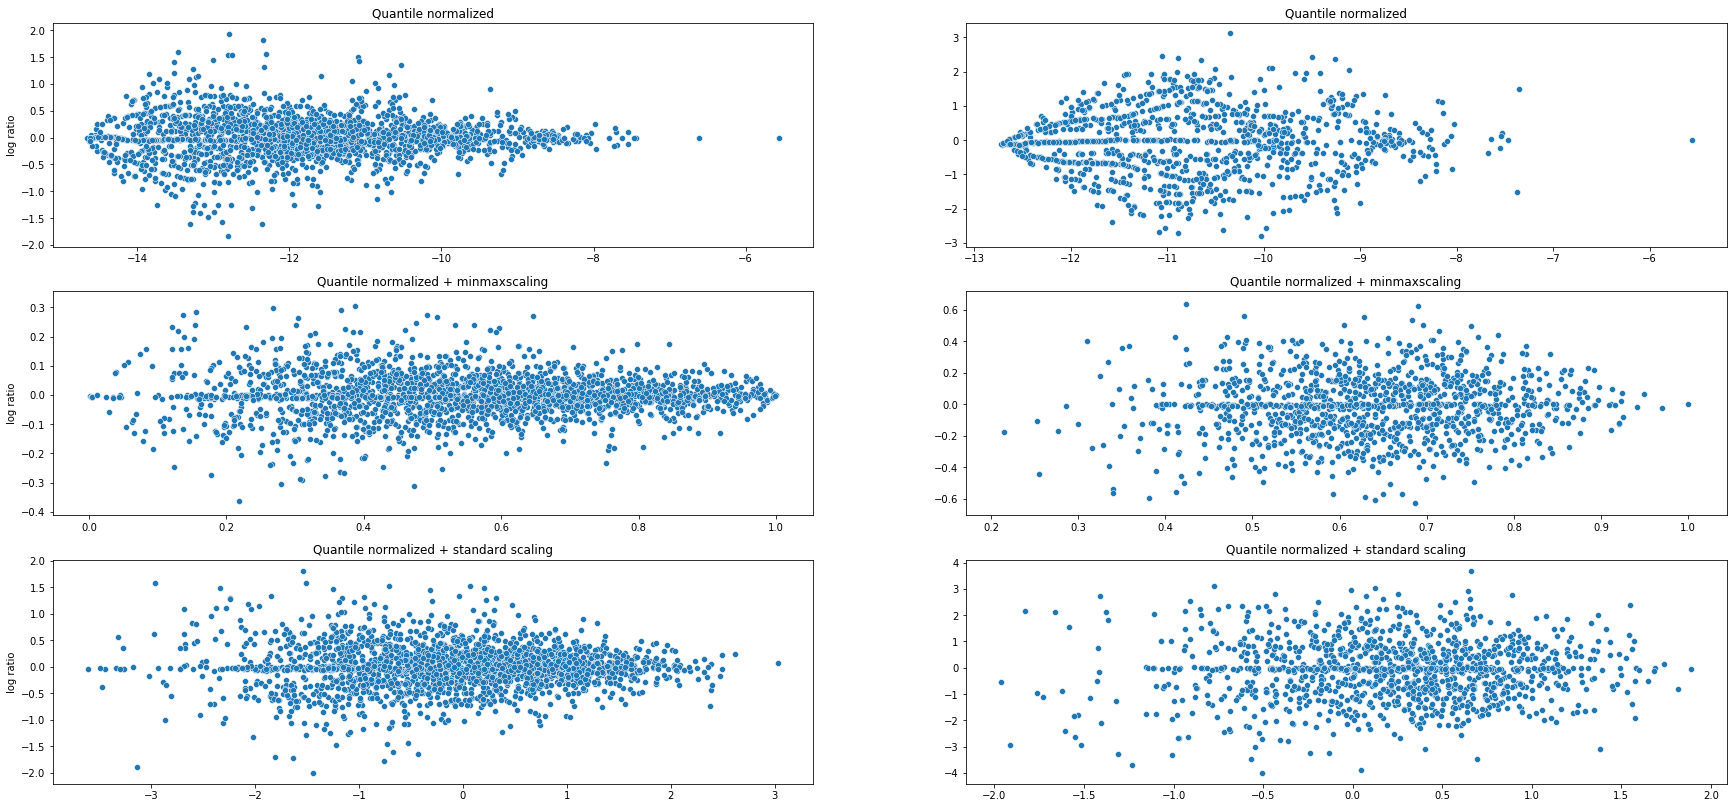

In [82]:
fig, ax = plt.subplots(3,2,figsize=(30,14))

ax[0][0].set_title("Quantile normalized")
ax[1][0].set_title("Quantile normalized + minmaxscaling")
ax[2][0].set_title("Quantile normalized + standard scaling")
ax[0][1].set_title("Quantile normalized")
ax[1][1].set_title("Quantile normalized + minmaxscaling")
ax[2][1].set_title("Quantile normalized + standard scaling")

ax[0][0].set_ylabel("log ratio")
ax[1][0].set_ylabel("log ratio")
ax[2][0].set_ylabel("log ratio")

sns.scatterplot(quantile_normalized_df.loc[[32003,32009],:].mean(axis=0), quantile_normalized_df.loc[32003,:].subtract(quantile_normalized_df.loc[32009,:]), ax=ax[0][0])
sns.scatterplot(quantile_normalized_df.loc[[32374,33066],:].mean(axis=0), quantile_normalized_df.loc[32374,:].subtract(quantile_normalized_df.loc[33066,:]), ax=ax[0][1])

sns.scatterplot(minmax_scaled_quantile.loc[[32003,32009],:].mean(axis=0), minmax_scaled_quantile.loc[32003,:].subtract(minmax_scaled_quantile.loc[32009,:]), ax=ax[1][0])
sns.scatterplot(minmax_scaled_quantile.loc[[32374,33066],:].mean(axis=0), minmax_scaled_quantile.loc[32374,:].subtract(minmax_scaled_quantile.loc[33066,:]), ax=ax[1][1])

sns.scatterplot(std_scaled_quantile.loc[[32003,32009],:].mean(axis=0), std_scaled_quantile.loc[32003,:].subtract(std_scaled_quantile.loc[32009,:]), ax=ax[2][0])
sns.scatterplot(std_scaled_quantile.loc[[32374,33066],:].mean(axis=0), std_scaled_quantile.loc[32374,:].subtract(std_scaled_quantile.loc[33066,:]), ax=ax[2][1])

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in 

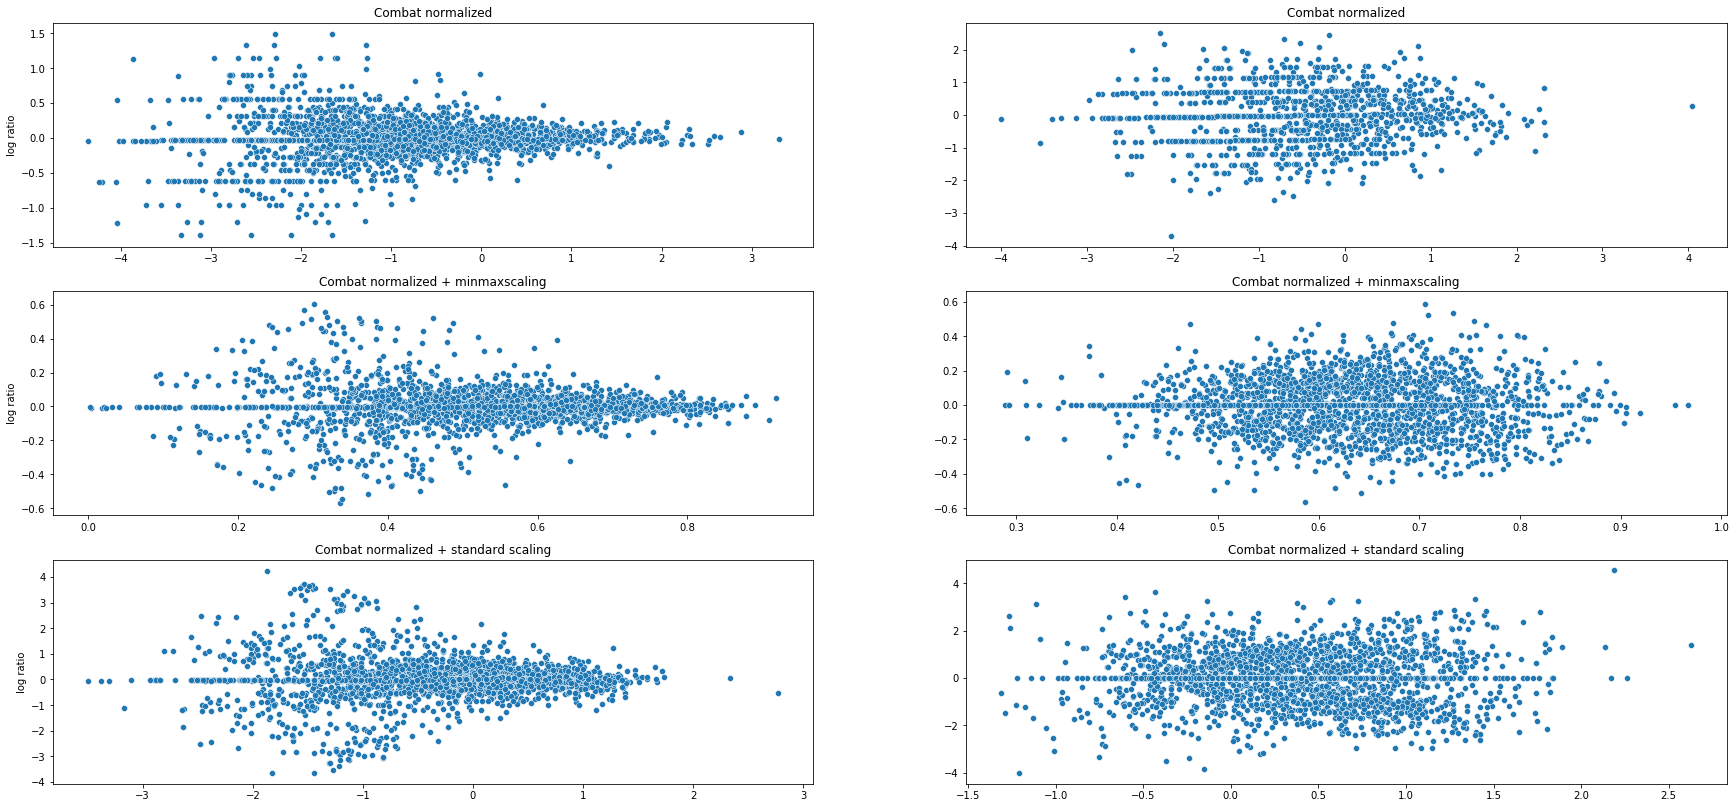

In [83]:
fig, ax = plt.subplots(3,2,figsize=(30,14))

ax[0][0].set_title("Combat normalized")
ax[1][0].set_title("Combat normalized + minmaxscaling")
ax[2][0].set_title("Combat normalized + standard scaling")
ax[0][1].set_title("Combat normalized")
ax[1][1].set_title("Combat normalized + minmaxscaling")
ax[2][1].set_title("Combat normalized + standard scaling")

ax[0][0].set_ylabel("log ratio")
ax[1][0].set_ylabel("log ratio")
ax[2][0].set_ylabel("log ratio")

sns.scatterplot(scaled_nsaf.loc[[32003,32009],:].mean(axis=0), scaled_nsaf.loc[32003,:].subtract(scaled_nsaf.loc[32009,:]), ax=ax[0][0])
sns.scatterplot(scaled_nsaf.loc[[32374,33066],:].mean(axis=0), scaled_nsaf.loc[32374,:].subtract(scaled_nsaf.loc[33066,:]), ax=ax[0][1])

sns.scatterplot(minmax_combat.loc[[32003,32009],:].mean(axis=0), minmax_combat.loc[32003,:].subtract(minmax_combat.loc[32009,:]), ax=ax[1][0])
sns.scatterplot(minmax_combat.loc[[32374,33066],:].mean(axis=0), minmax_combat.loc[32374,:].subtract(minmax_combat.loc[33066,:]), ax=ax[1][1])

sns.scatterplot(std_combat.loc[[32003,32009],:].mean(axis=0), std_combat.loc[32003,:].subtract(std_combat.loc[32009,:]), ax=ax[2][0])
sns.scatterplot(std_combat.loc[[32374,33066],:].mean(axis=0), std_combat.loc[32374,:].subtract(std_combat.loc[33066,:]), ax=ax[2][1])

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:54: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



(            0            Type  Group
 0    0.980190  Within project    HCC
 1    0.816349  Within project    HCC
 2    0.813129  Within project    HCC
 3    0.805534  Within project    HCC
 4    0.804413  Within project    HCC
 ..        ...             ...    ...
 856  0.809794  Within project  HGSOC
 857  0.801459  Within project  HGSOC
 858  0.948711  Within project  HGSOC
 859  0.944432  Within project  HGSOC
 860  0.954900  Within project  HGSOC
 
 [13611 rows x 3 columns],
             0            Type  Group
 0    0.873757  Within project  HGSOC
 1    0.875513  Within project  HGSOC
 2    0.788131  Within project  HGSOC
 3    0.778475  Within project  HGSOC
 4    0.790197  Within project  HGSOC
 ..        ...             ...    ...
 856  0.809794  Within project  HGSOC
 857  0.801459  Within project  HGSOC
 858  0.948711  Within project  HGSOC
 859  0.944432  Within project  HGSOC
 860  0.954900  Within project  HGSOC
 
 [861 rows x 3 columns])

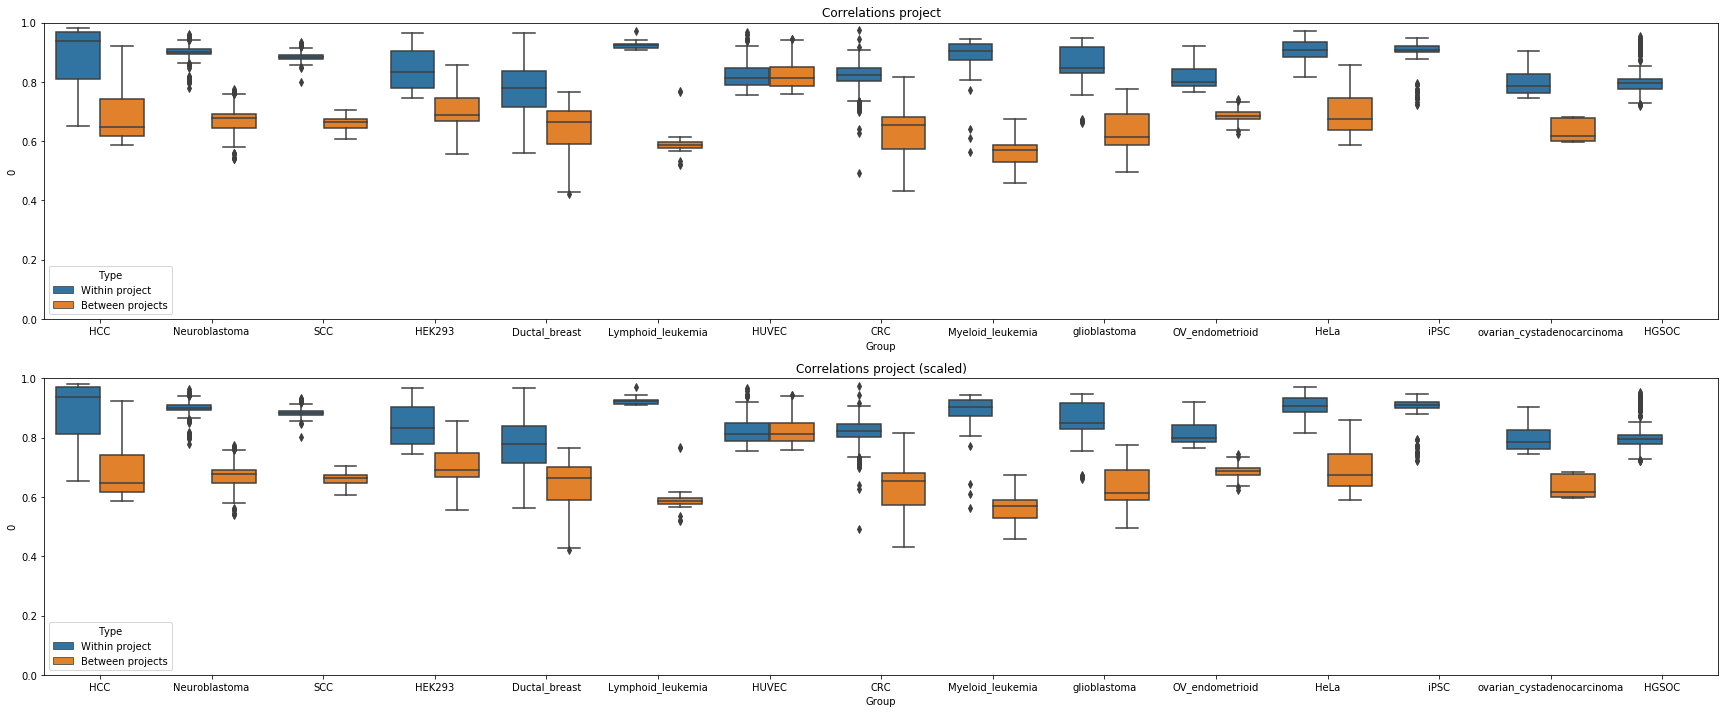

In [145]:
calculate_correlations_bygroup(scaled_nsaf)

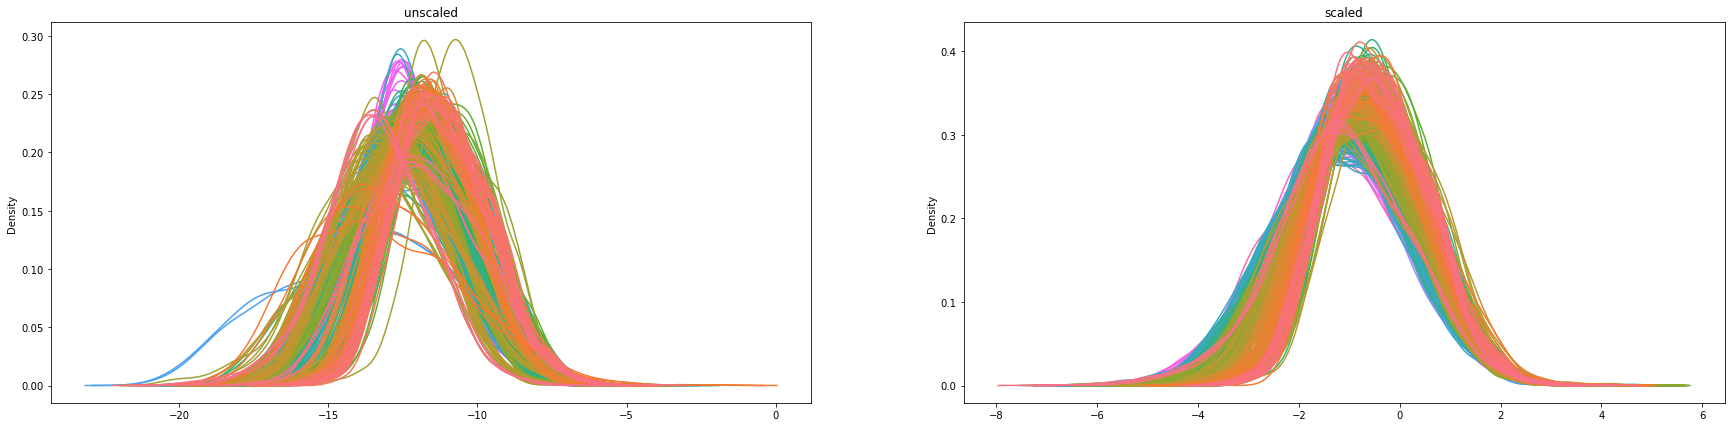

In [67]:
# Plotting the abundance values of the full and the filtered dataset
fig, ax = plt.subplots(1,2,figsize=(30,7))

ax[0].set_title('unscaled')
sns.kdeplot(data=np.log2(nsaf_filtered).transpose(), legend = False, common_norm=False, ax =ax[0])

ax[1].set_title("scaled")
sns.kdeplot(data=scaled_nsaf.transpose(), legend = False, common_norm=False, ax =ax[1])

---

# Quantile normalization

In [12]:
ranked_df = nsaf_filtered.fillna(100).rank(axis=1, method="min").multiply(1/nsaf_filtered.notna().sum(axis=1), axis="index")
ranked_df = ranked_df.applymap(lambda x: 0 if x>1 else x)

In [13]:
sorted_arrays = []
for i, row in np.log2(nsaf_filtered).iterrows():
    
    # Sorts the row from smallest to biggest and putting the nans at the back
    row = np.sort(np.array(row))
    sorted_arrays.append(row)
sorted_df = pd.DataFrame(sorted_arrays)

In [14]:
rank_mean = sorted_df.mean().sort_values()
rank_median = sorted_df.median().sort_values()

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


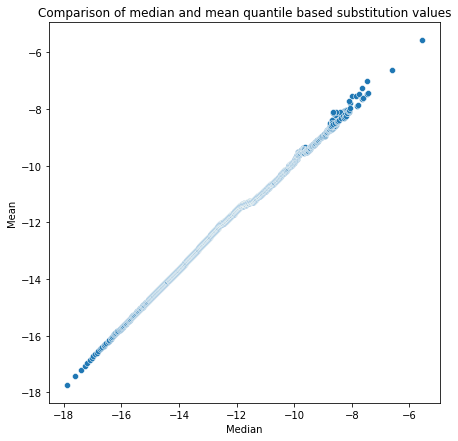

In [72]:
plt.figure(figsize=(7,7))
plt.xlabel("Median")
plt.ylabel("Mean")
#plt.ylim((-.001,.01))
#plt.xlim((-.001, 0.01))
plt.title("Comparison of median and mean quantile based substitution values")
sns.scatterplot(x=rank_median.dropna(),
                y=rank_mean.dropna())
#plt.plot([0,.01], [0,.01], color='r')

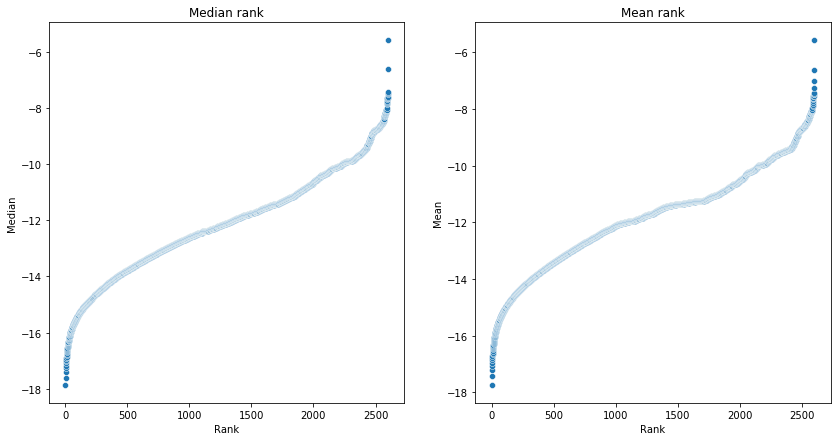

In [73]:
fig, ax = plt.subplots(1,2, figsize=(14,7))
#ax[0].set_ylim((-.001, 0.01))
#ax[1].set_ylim((-.001, 0.01))
ax[0].set_title("Median rank")
ax[1].set_title("Mean rank")

ax[0].set_ylabel("Median")
ax[1].set_ylabel("Mean")

ax[0].set_xlabel("Rank")
ax[1].set_xlabel("Rank")

sns.scatterplot(x=list(range(len(rank_median.dropna()))), y=rank_median.dropna(), ax=ax[0])
sns.scatterplot(x=list(range(len(rank_mean.dropna()))), y=rank_mean.dropna(), ax=ax[1])

In [15]:
rank_median = pd.DataFrame(rank_median.dropna(), columns=["Rank_substitution"])
rank_median["index"] = list(range(len(rank_median), 0,-1))
rank_median = rank_median.set_index("index")
rank_mapper = {float(x):rank_median.loc[x].values[0] for x in range(1,len(rank_median)+1)}
rank_median

Rank_substitution
index                   
2604          -17.876127
2603          -17.608116
2602          -17.415085
2601          -17.272425
2600          -17.183880
...                  ...
5              -7.487611
4              -7.464297
3              -7.437607
2              -6.616180
1              -5.565813

[2604 rows x 1 columns]

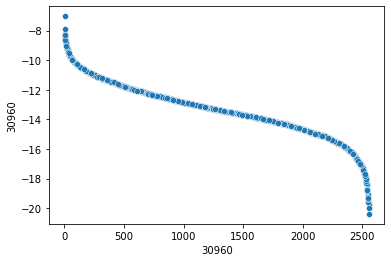

In [66]:
sns.scatterplot(x=nsaf_filtered.rank(axis=1, method="average", na_option="keep", ascending=False).iloc[0,:], y=np.log2(nsaf_filtered.iloc[0,:]))

In [16]:
ranked_df = nsaf_filtered.rank(axis=1, method="average", na_option="keep", ascending=False)

In [17]:
import math
def replace_values(x):
    if np.isnan(x):
        return np.nan
    elif x not in rank_mapper.keys():
        return np.mean([rank_mapper[math.ceil(x)], rank_mapper[math.ceil(x)-1]])
    else:
        return rank_mapper[x]

In [18]:
quantile_normalized_df = ranked_df.applymap(lambda x: replace_values(x))

In [79]:
quantile_normalized_df.max(axis=1)

assay_id
30960   -5.565813
30961   -5.565813
31008   -5.565813
31009   -5.565813
31102   -5.565813
           ...   
36558   -5.565813
36563   -5.565813
36568   -5.565813
36573   -5.565813
36578   -5.565813
Length: 518, dtype: float64

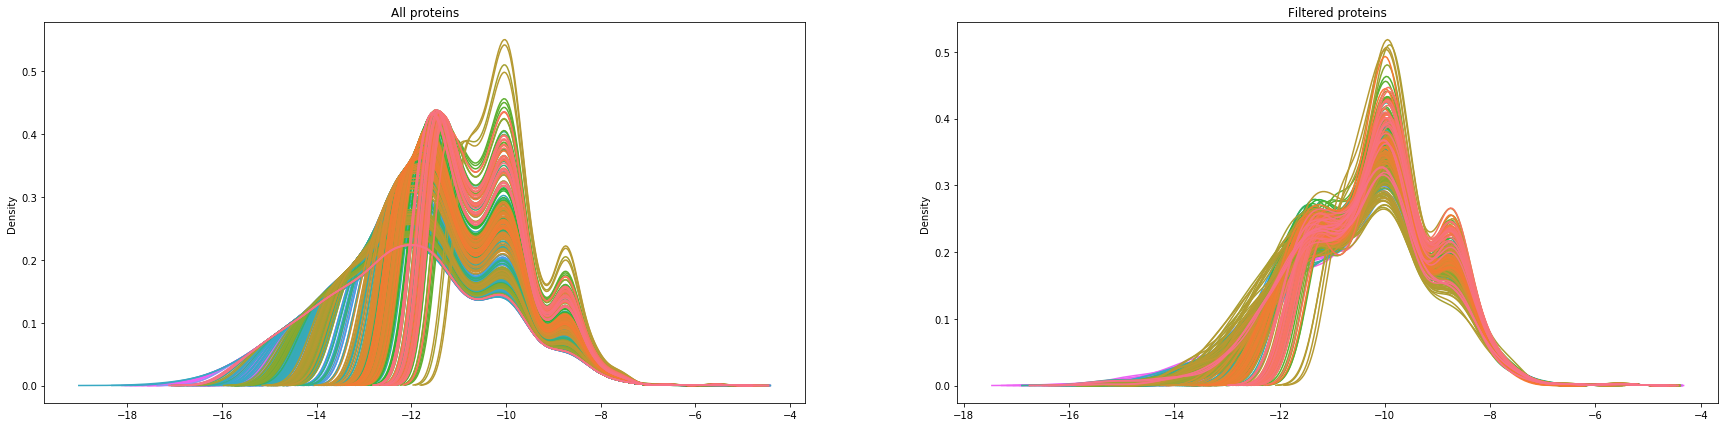

In [82]:
# Plotting the abundance values of the full and the filtered dataset
fig, ax = plt.subplots(1,2,figsize=(30,7))

ax[0].set_title('All proteins')
sns.kdeplot(data=quantile_normalized_df.transpose(), legend = False, common_norm=False, ax =ax[0])

ax[1].set_title("Filtered proteins")
sns.kdeplot(data=quantile_normalized_df.loc[:, filtered_90.columns].transpose(), legend = False, common_norm=False, ax =ax[1])

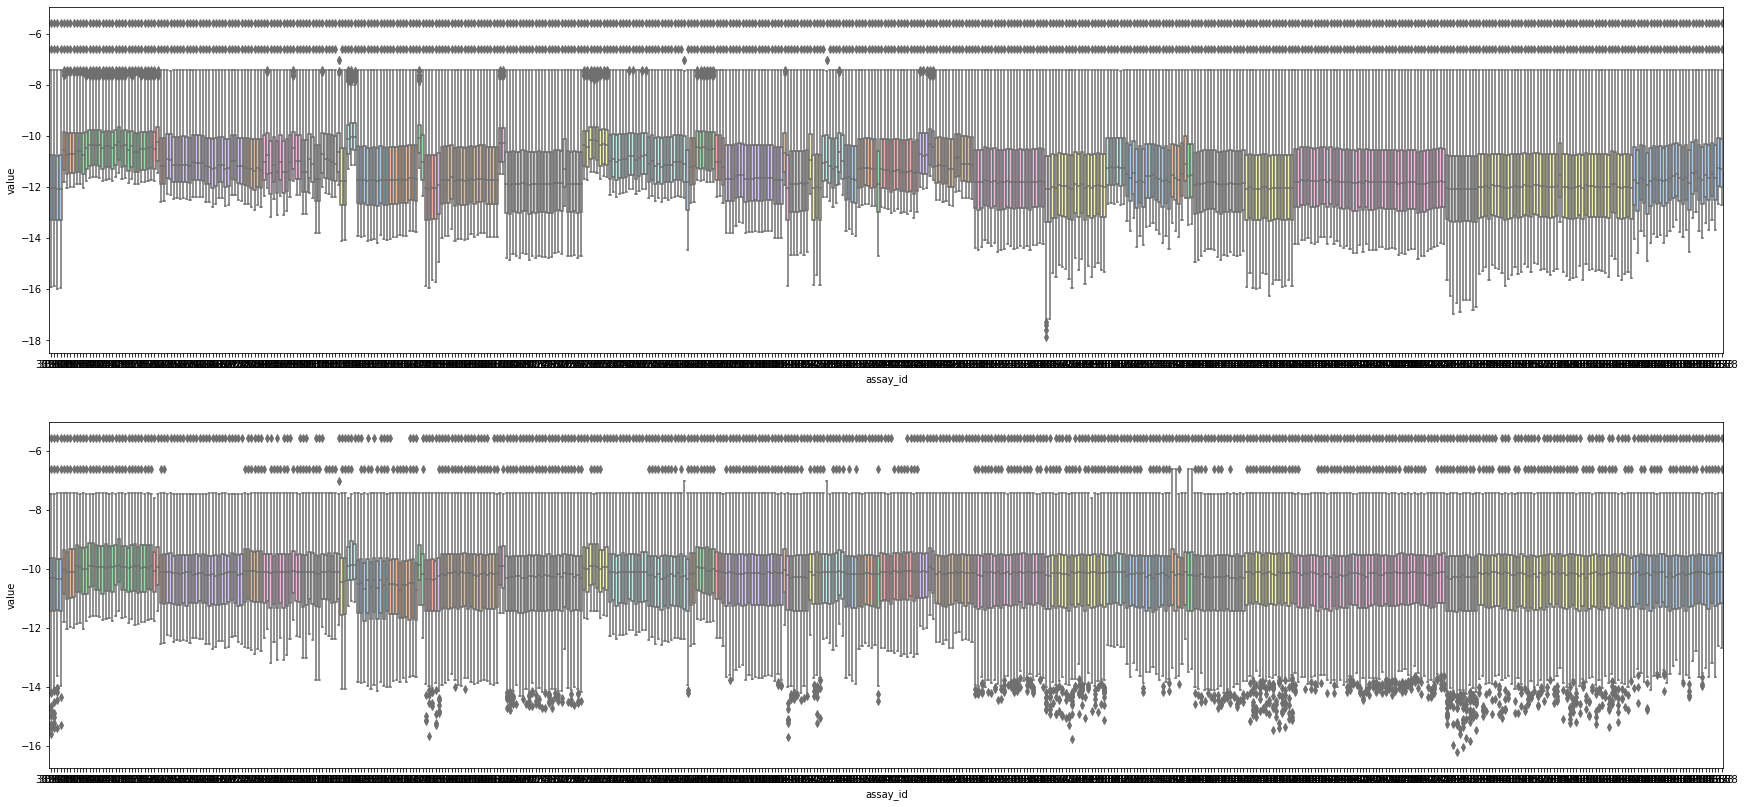

In [111]:
fig, ax = plt.subplots(2,1,figsize=(30,14))
sns.boxplot(data=quantile_normalized_df.T.melt().dropna(), y='value', x="assay_id", ax=ax[0], palette=meta.PXD_accession.apply(lambda x: mapper[x]).values)
sns.boxplot(data=quantile_normalized_df.loc[:, filtered_90.columns].T.melt().dropna(), y='value', x="assay_id", ax=ax[1], palette=meta.PXD_accession.apply(lambda x: mapper[x]).values)

In [45]:
quantile_normalized_df.iloc[0,:].subtract(quantile_normalized_df.iloc[1,:])

uniprot_id
A0AVT1    0.062276
A0MZ66    0.007583
A0PJW6   -0.618461
A1X283   -0.294736
A2RRP1    0.167389
            ...   
Q9Y6W3   -0.179396
Q9Y6W5    0.002969
Q9Y6X9   -0.077196
Q9Y6Y0    0.484564
Q9Y6Y8    0.268373
Length: 2615, dtype: float64

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


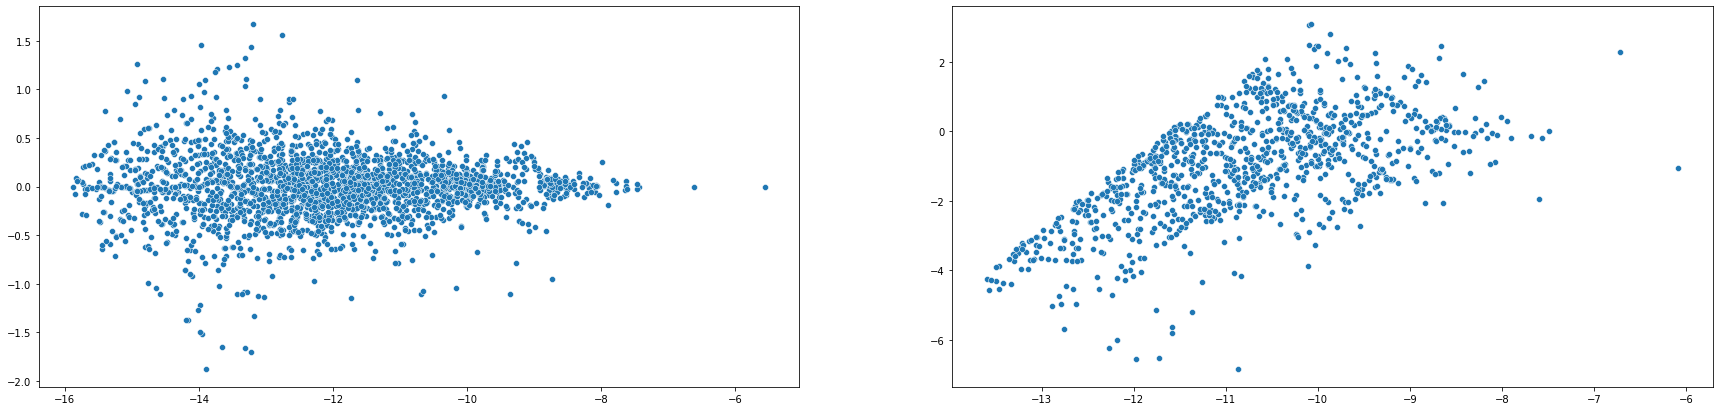

In [38]:
fig, ax = plt.subplots(1,2,figsize=(30,7))
sns.scatterplot(quantile_normalized_df.iloc[[0,1],:].mean(axis=0), quantile_normalized_df.iloc[0,:].subtract(quantile_normalized_df.iloc[1,:]), ax=ax[0])
sns.scatterplot(quantile_normalized_df.iloc[[0,20],:].mean(axis=0), quantile_normalized_df.iloc[0,:].subtract(quantile_normalized_df.iloc[20,:]), ax=ax[1])

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


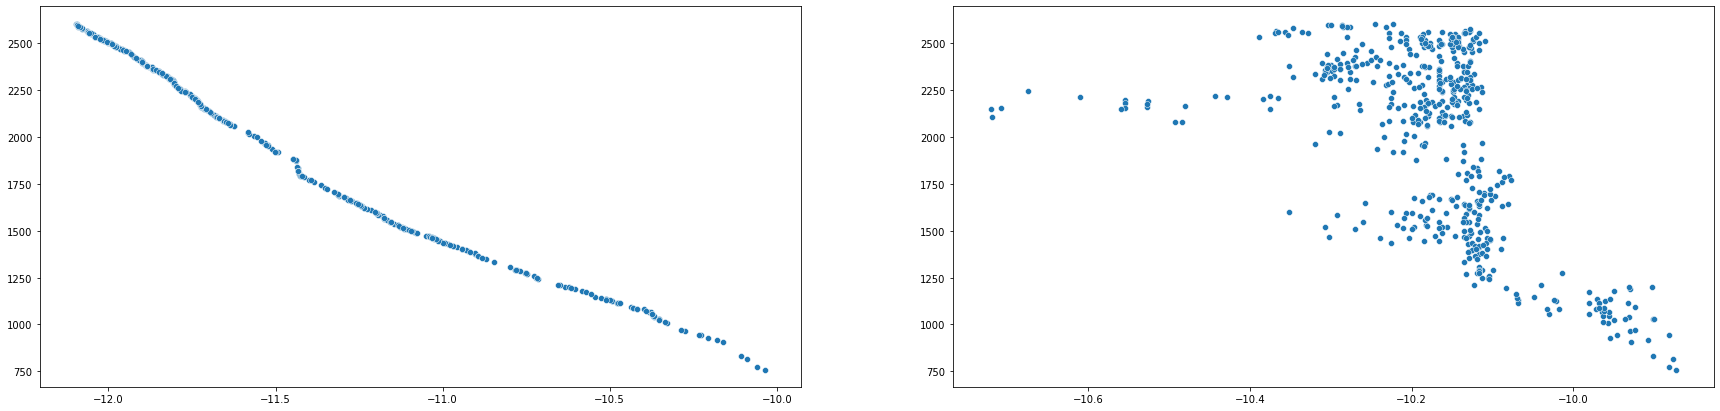

In [125]:
fig, ax = plt.subplots(1,2,figsize=(30,7))
sns.scatterplot(quantile_normalized_df.median(axis=1), nsaf_filtered.notna().sum(axis=1), ax=ax[0])
sns.scatterplot(quantile_normalized_df.loc[:, filtered_90.columns].median(axis=1), nsaf_filtered.notna().sum(axis=1), ax=ax[1])

In [84]:
quantile_normalized_df.to_csv("quantile_norm_NSAF_50.csv")

In [85]:
from itertools import combinations

In [143]:
def calculate_correlations_bygroup(scaled_dataset):

    groups = meta.Group.unique()

    within_corr_g = []
    between_corr_g = []
    within_corr_sca_g = []
    between_corr_sca_g = []

    for group in groups:

        within_corr, between_corr = calculate_correlations(np.log2(nsaf_filtered), meta[meta.Group == group].index)
        within_corr_sca, between_corr_sca = calculate_correlations(scaled_dataset, meta[meta.Group == group].index)

        all_within_corr = []
        for px, x in within_corr.items():
            all_within_corr+=x
            #print(px, np.mean(x))

        all_between_corr = []
        for x in between_corr.values():
            all_between_corr += x

        all_within_corr_sca = []
        for px, x in within_corr_sca.items():
            all_within_corr_sca+=x
            #print(px, np.mean(x))

        all_between_corr_sca = []
        for x in between_corr_sca.values():
            all_between_corr_sca += x

        within_corr_g.append(all_within_corr)
        between_corr_g.append(all_between_corr)
        within_corr_sca_g.append(all_within_corr_sca)
        between_corr_sca_g.append(all_between_corr_sca)

    fig, ax = plt.subplots(2,1, figsize=(30,12))

    ax[0].set_title("Correlations project")
    ax[0].set_ylim((0,1))
    ax[1].set_title("Correlations project (scaled)")
    ax[1].set_ylim((0,1))

    dfs = []
    dfs_sca = []

    for i, g in enumerate(groups):

        all_within = pd.DataFrame(data=within_corr_g[i])
        all_within["Type"] = "Within project"
        all_between = pd.DataFrame(data=between_corr_g[i])
        all_between["Type"] = "Between projects"
        corr_df = pd.concat([all_within,all_between])
        corr_df["Group"] = g
        dfs.append(corr_df)

        all_within_sca = pd.DataFrame(data=within_corr_sca_g[i])
        all_within_sca["Type"] = "Within project"
        all_between_sca = pd.DataFrame(data=between_corr_sca_g[i])
        all_between_sca["Type"] = "Between projects"
        corr_df_sca = pd.concat([all_within_sca,all_between_sca])
        corr_df_sca["Group"] = g
        dfs_sca.append(corr_df_sca)
    
    corr_df_g = pd.concat(dfs)
    corr_df_sca_g = pd.concat(dfs_sca)

    sns.boxplot(data=corr_df_g,x="Group", y=0, hue="Type", ax=ax[0])
    sns.boxplot(data=corr_df_sca_g,x="Group", y=0, hue="Type", ax=ax[1])

    return corr_df_g, corr_df_sca

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:54: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



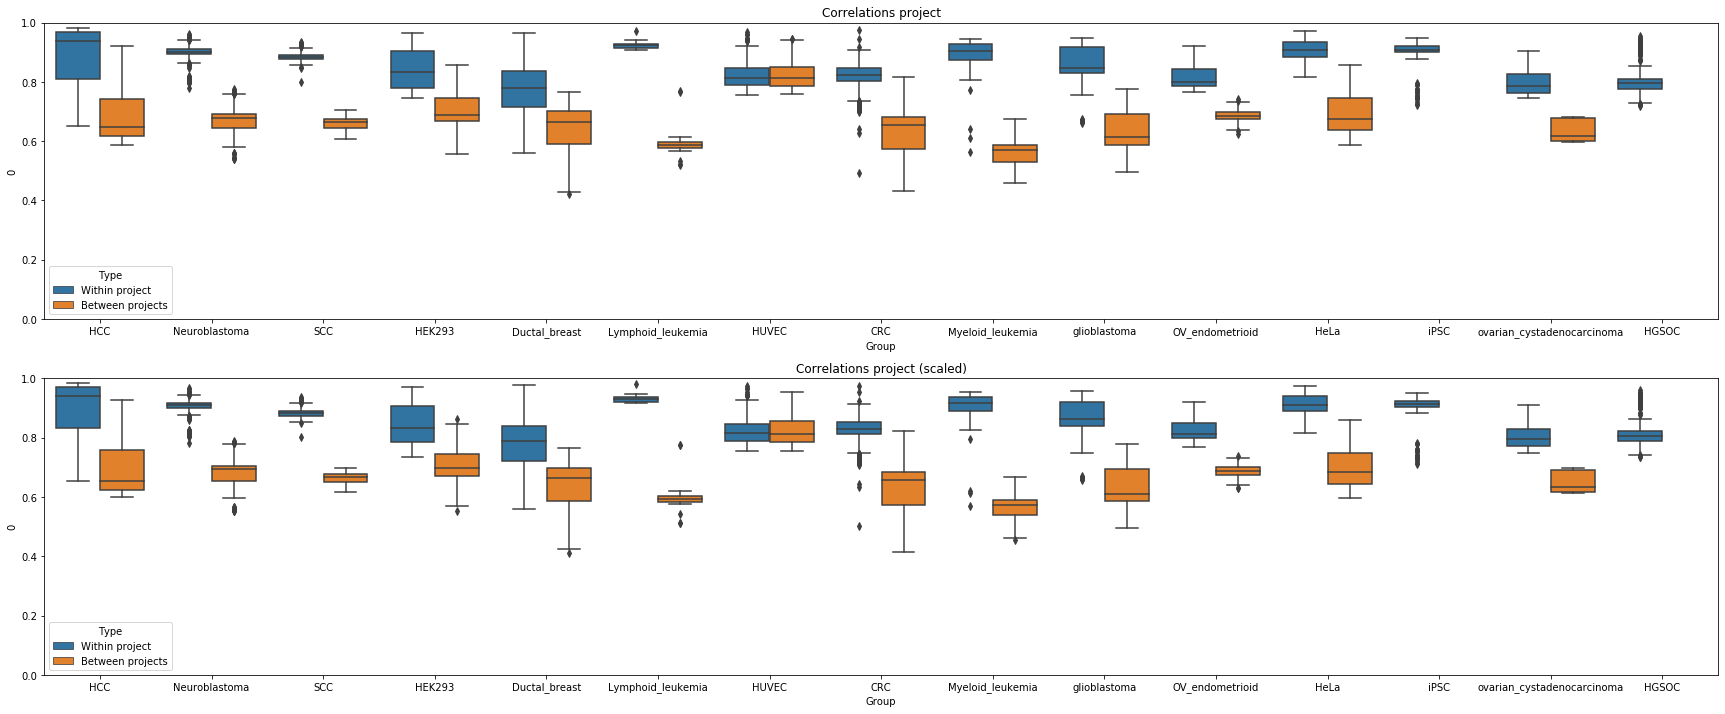

In [144]:
corr_df_quant, corr_df_scaled_quant = calculate_correlations_bygroup(quantile_normalized_df)

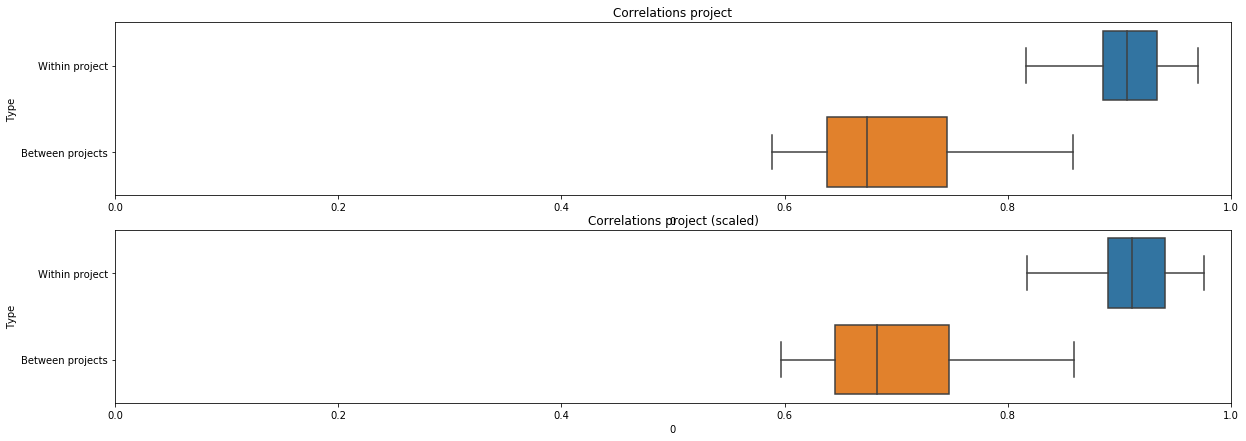

In [90]:
calculate_correlations_bygroup("HeLa", quantile_normalized_df)

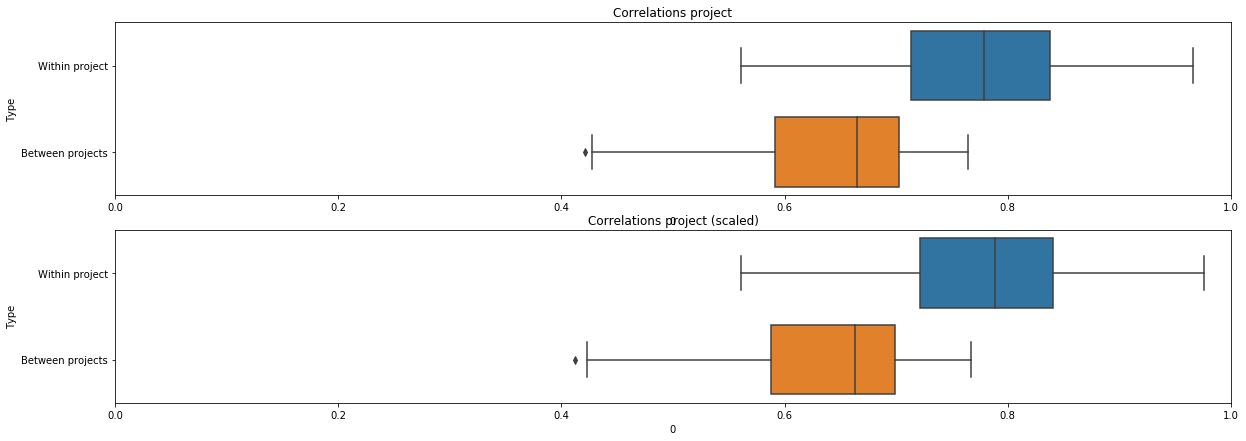

In [91]:
calculate_correlations_bygroup("Ductal_breast", quantile_normalized_df)

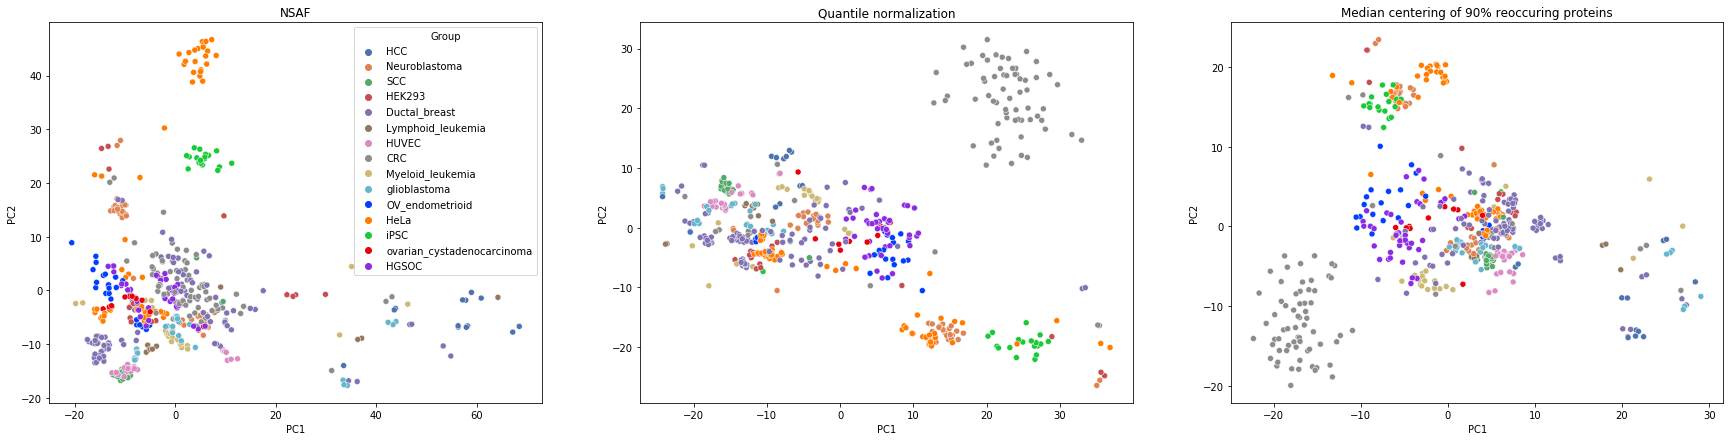

In [21]:
from sklearn.impute import SimpleImputer

imputer1 = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer1.fit(np.log2(nsaf_filtered))
X1 = imputer1.transform(np.log2(nsaf_filtered))

imputer2 = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer2.fit(quantile_normalized_df)
X2 = imputer2.transform(quantile_normalized_df)

imputer3 = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer3.fit(scaled_nsaf)
X3 = imputer3.transform(scaled_nsaf)

fig, ax = plt.subplots(1,3,figsize=(30,7))

ax[0].set_title("NSAF")
ax[1].set_title("Quantile normalization")
ax[2].set_title("Median centering of 90% reoccuring proteins")

embedding = PCA(n_components=2).fit_transform(X1)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.Group, palette=colors[:15], ax=ax[0])

embedding = PCA(n_components=2).fit_transform(X2)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.Group, palette=colors[:15], legend=False, ax=ax[1])

embedding = PCA(n_components=2).fit_transform(X3)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.Group, palette=colors[:15], legend=False, ax=ax[2])

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'ran

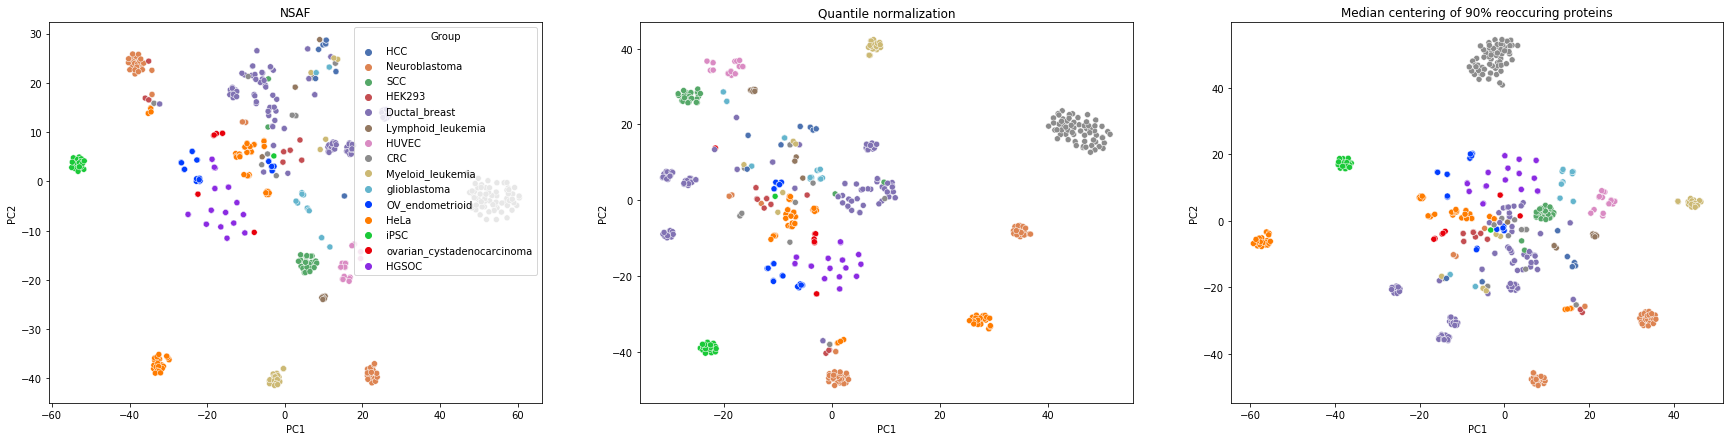

In [112]:
fig, ax = plt.subplots(1,3,figsize=(30,7))

ax[0].set_title("NSAF")
ax[1].set_title("Quantile normalization")
ax[2].set_title("Median centering of 90% reoccuring proteins")

embedding = TSNE(perplexity=20).fit_transform(X1)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.Group, palette=colors[:15], ax=ax[0])

embedding = TSNE(perplexity=20).fit_transform(X2)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.Group, palette=colors[:15], legend=False, ax=ax[1])

embedding = TSNE(perplexity=20).fit_transform(X3)
sns.scatterplot(data=pd.DataFrame(embedding, index= nsaf_filtered.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.Group, palette=colors[:15], legend=False, ax=ax[2])

# Pycombat

In [19]:
from combat.pycombat import pycombat

In [22]:
combat_df = pycombat(pd.DataFrame(X1).T, meta.Group.tolist())
combat_df = combat_df.T

Found 15 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/combat/pycombat.py:158: RuntimeWarning: invalid value encountered in true_divide
  change = max(np.amax(np.absolute(g_new-np.asarray(g_old))/np.asarray(g_old)), np.amax(
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/combat/pycombat.py:159: RuntimeWarning: divide by zero encountered in true_divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


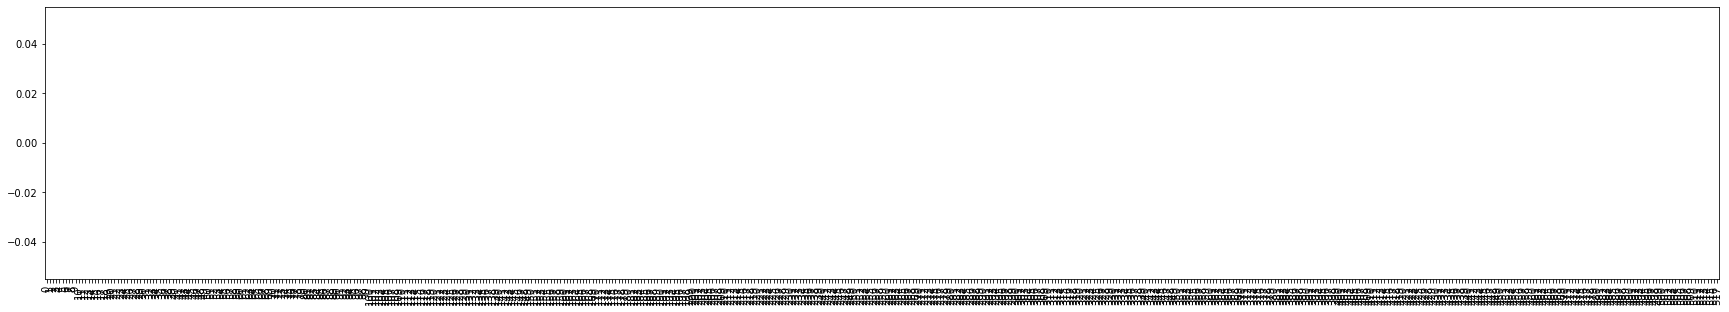

In [98]:
combat_df.isna().sum(axis=1).plot(kind="bar", figsize=(30,5))

In [23]:
combat_df = combat_df.set_index(nsaf_filtered.index)
combat_df = combat_df.dropna()

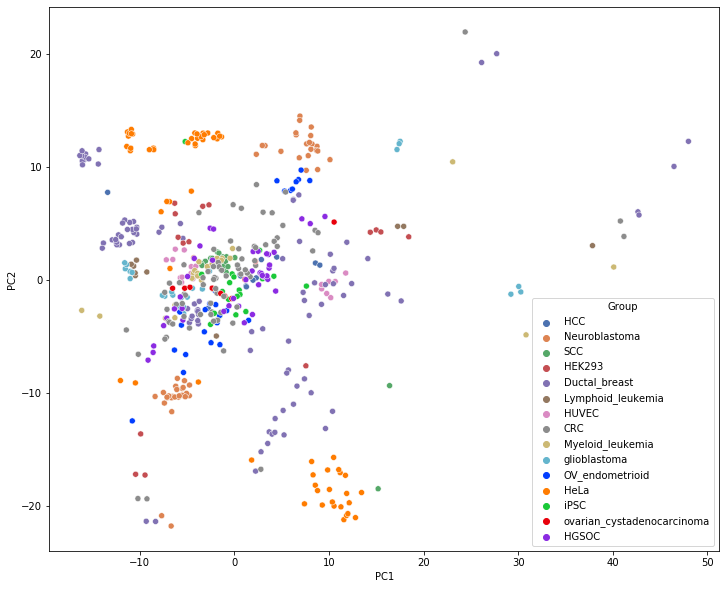

In [104]:
embedding = PCA(n_components=2).fit_transform(combat_df)

plt.figure(figsize=(12,10))
sns.scatterplot(data=pd.DataFrame(embedding, index= combat_df.index,columns=["PC1", "PC2"]), x="PC1", y="PC2", hue=meta.loc[combat_df.index, "Group"], palette=colors[:15])

In [106]:
# Plotting the abundance values of the full and the filtered dataset
fig, ax = plt.subplots(1,1,figsize=(15,7))

ax.set_title('Filtered proteins')
sns.kdeplot(data=combat_df.transpose(), legend = False, common_norm=False, ax =ax)

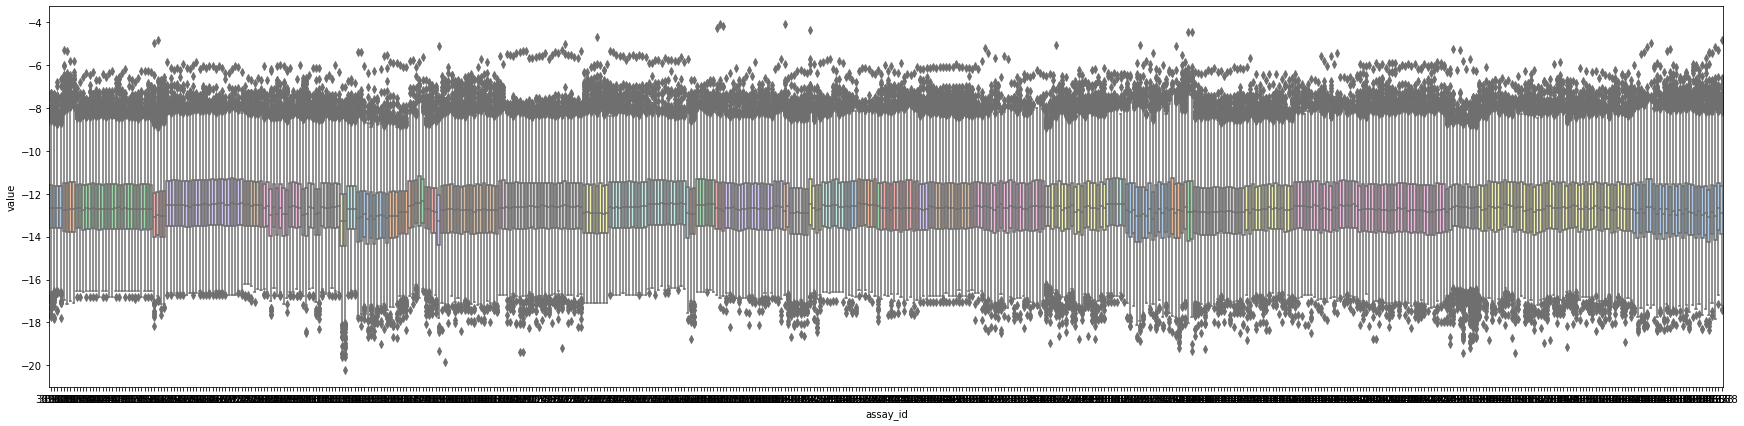

In [113]:
fig, ax = plt.subplots(1,1,figsize=(30,7))
sns.boxplot(data=combat_df.T.melt().dropna(), y='value', x="assay_id", palette=meta.PXD_accession.apply(lambda x: mapper[x]).values ,ax=ax)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


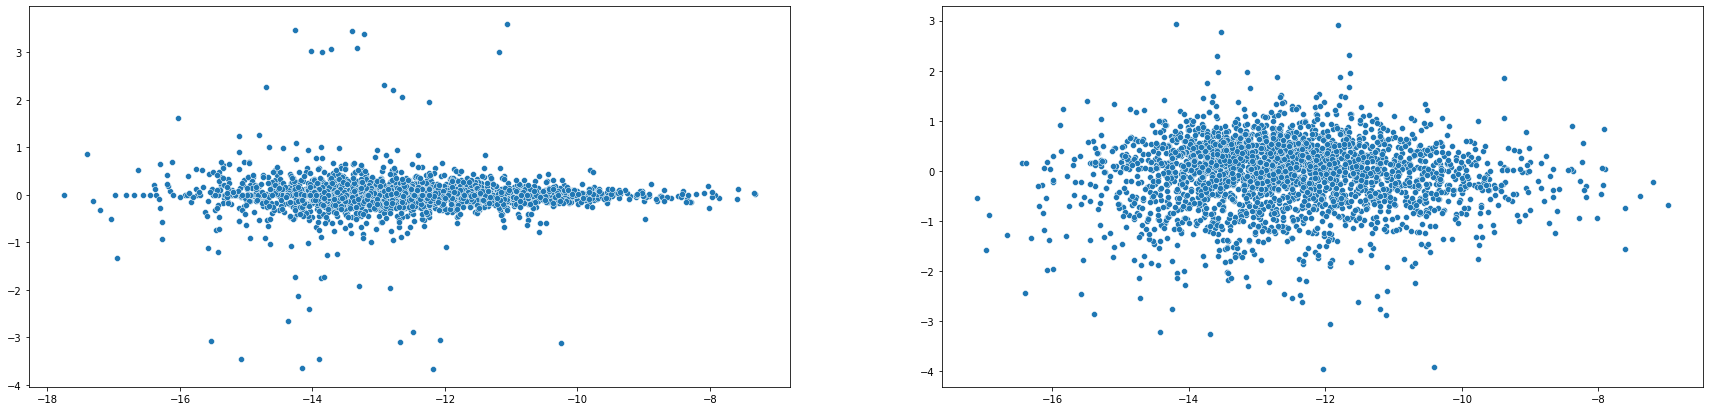

In [51]:
fig, ax = plt.subplots(1,2,figsize=(30,7))
sns.scatterplot(combat_df.iloc[[0,1],:].mean(axis=0), combat_df.iloc[0,:].subtract(combat_df.iloc[1,:]), ax=ax[0])
sns.scatterplot(combat_df.iloc[[0,20],:].mean(axis=0), combat_df.iloc[0,:].subtract(combat_df.iloc[20,:]), ax=ax[1])

In [129]:
combat_df = combat_df.rename(columns={i: nsaf_filtered.columns[i] for i in range(2615)})

In [130]:
fig, ax = plt.subplots(1,2,figsize=(30,7))
sns.scatterplot(combat_df.median(axis=1), nsaf_filtered.notna().sum(axis=1), ax=ax[0])
sns.scatterplot(combat_df.loc[:, filtered_90.columns].median(axis=1), nsaf_filtered.notna().sum(axis=1), ax=ax[1])

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:54: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



(            0            Type  Group
 0    0.980190  Within project    HCC
 1    0.816349  Within project    HCC
 2    0.813129  Within project    HCC
 3    0.805534  Within project    HCC
 4    0.804413  Within project    HCC
 ..        ...             ...    ...
 856  0.809794  Within project  HGSOC
 857  0.801459  Within project  HGSOC
 858  0.948711  Within project  HGSOC
 859  0.944432  Within project  HGSOC
 860  0.954900  Within project  HGSOC
 
 [13611 rows x 3 columns],
             0            Type  Group
 0    0.875211  Within project  HGSOC
 1    0.879161  Within project  HGSOC
 2    0.799727  Within project  HGSOC
 3    0.796584  Within project  HGSOC
 4    0.807365  Within project  HGSOC
 ..        ...             ...    ...
 856  0.810975  Within project  HGSOC
 857  0.808622  Within project  HGSOC
 858  0.934143  Within project  HGSOC
 859  0.934802  Within project  HGSOC
 860  0.945020  Within project  HGSOC
 
 [861 rows x 3 columns])

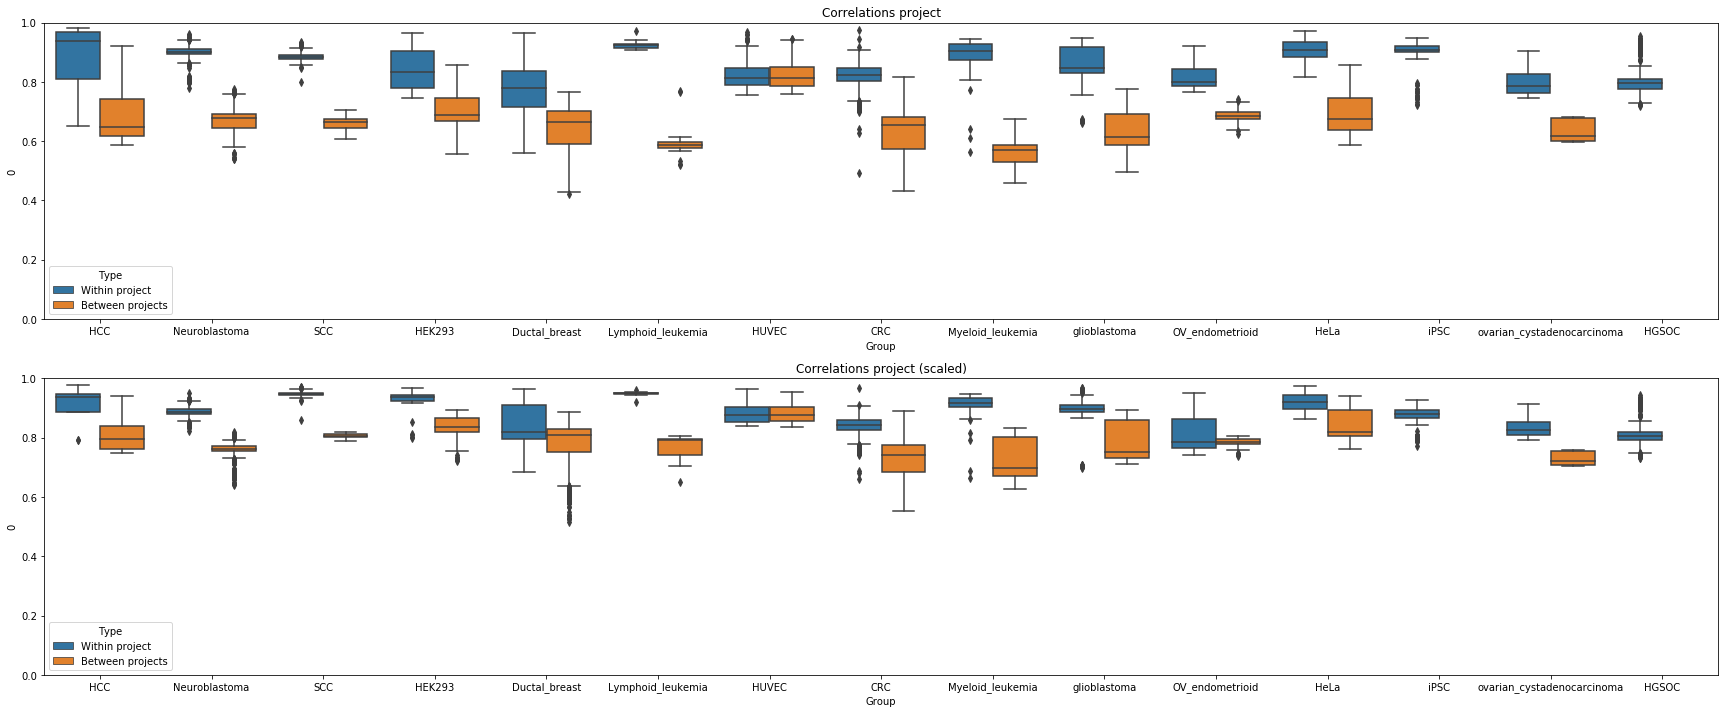

In [146]:
calculate_correlations_bygroup(combat_df)

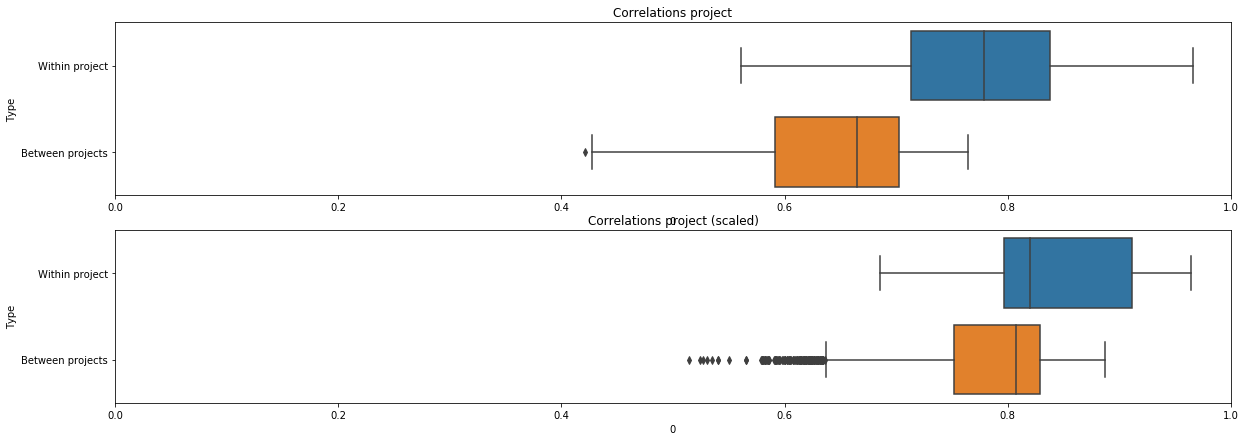

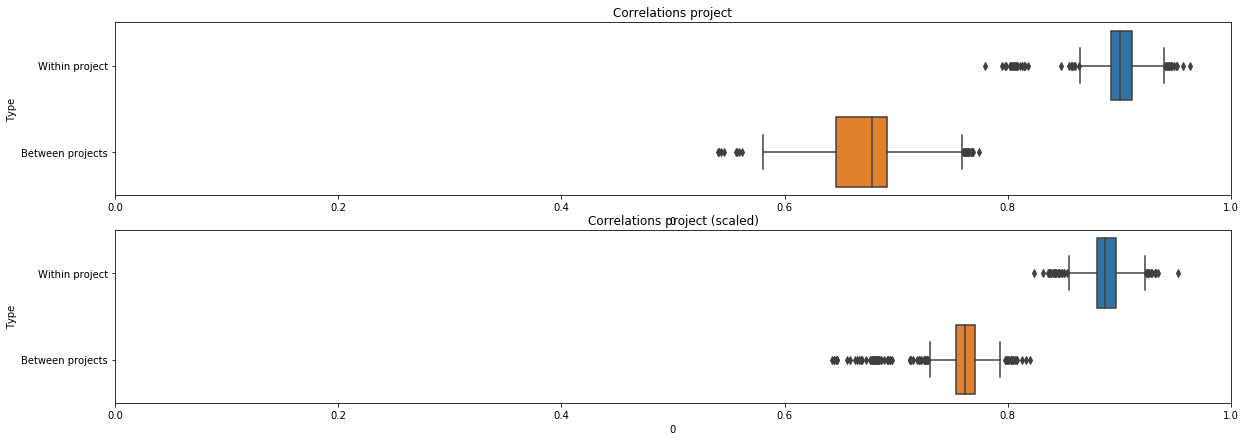

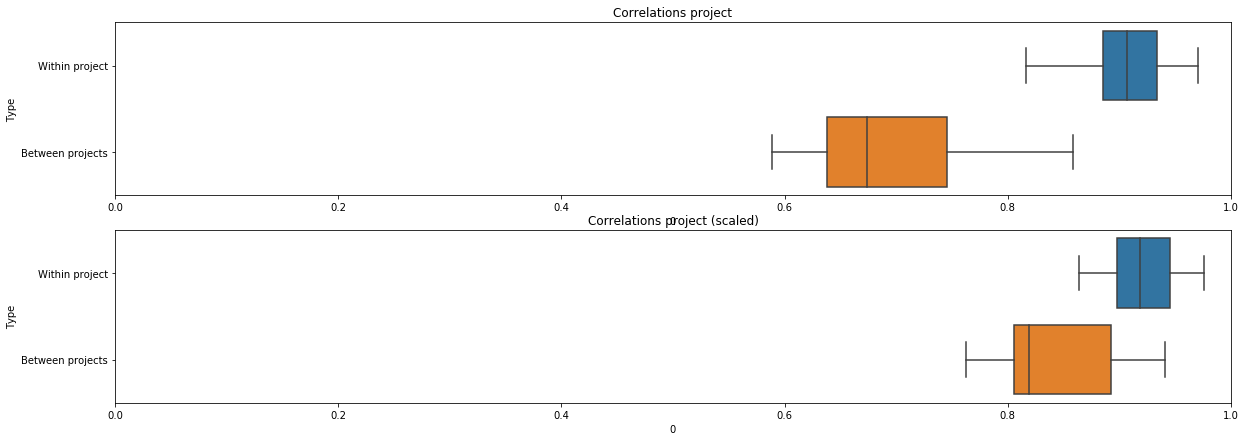

In [115]:
calculate_correlations_bygroup("Ductal_breast", combat_df)
calculate_correlations_bygroup("Neuroblastoma", combat_df)
calculate_correlations_bygroup("HeLa", combat_df)

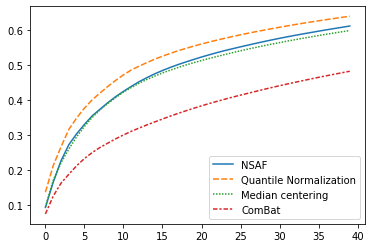

In [102]:
pc1 = PCA(n_components = 40)
pc2 = PCA(n_components = 40)
pc3 = PCA(n_components = 40)
pc4 = PCA(n_components = 40)

embedding = pc1.fit_transform(X1)
embedding = pc2.fit_transform(X2)
embedding = pc3.fit_transform(X3)
embedding = pc4.fit_transform(combat_df)

sns.lineplot(data=pd.DataFrame({"NSAF": np.cumsum(pc1.explained_variance_ratio_),
            "Quantile Normalization": np.cumsum(pc2.explained_variance_ratio_),
            "Median centering": np.cumsum(pc3.explained_variance_ratio_),
            "ComBat": np.cumsum(pc4.explained_variance_ratio_)}))

In [147]:
combat_df.to_csv("combat_NSAF_50.csv")
quantile_normalized_df.to_csv("quantile_norm_NSAF_50.csv")
scaled_nsaf.to_csv("median_scaling_50.csv")
nsaf_filtered.to_csv("NSAF_50.csv")

In [272]:
nsaf_filtered.to_csv("NSAF_50.csv")

# Which proteins are least variable?

In [197]:
lowest_std = np.log2(nsaf_filtered).std().sort_values().reset_index()
lowest_std_quant = quantile_normalized_df.std().sort_values().reset_index()
lowest_std_med = scaled_nsaf.std().sort_values().reset_index()
lowest_std_combat = combat_df.std().sort_values().reset_index()

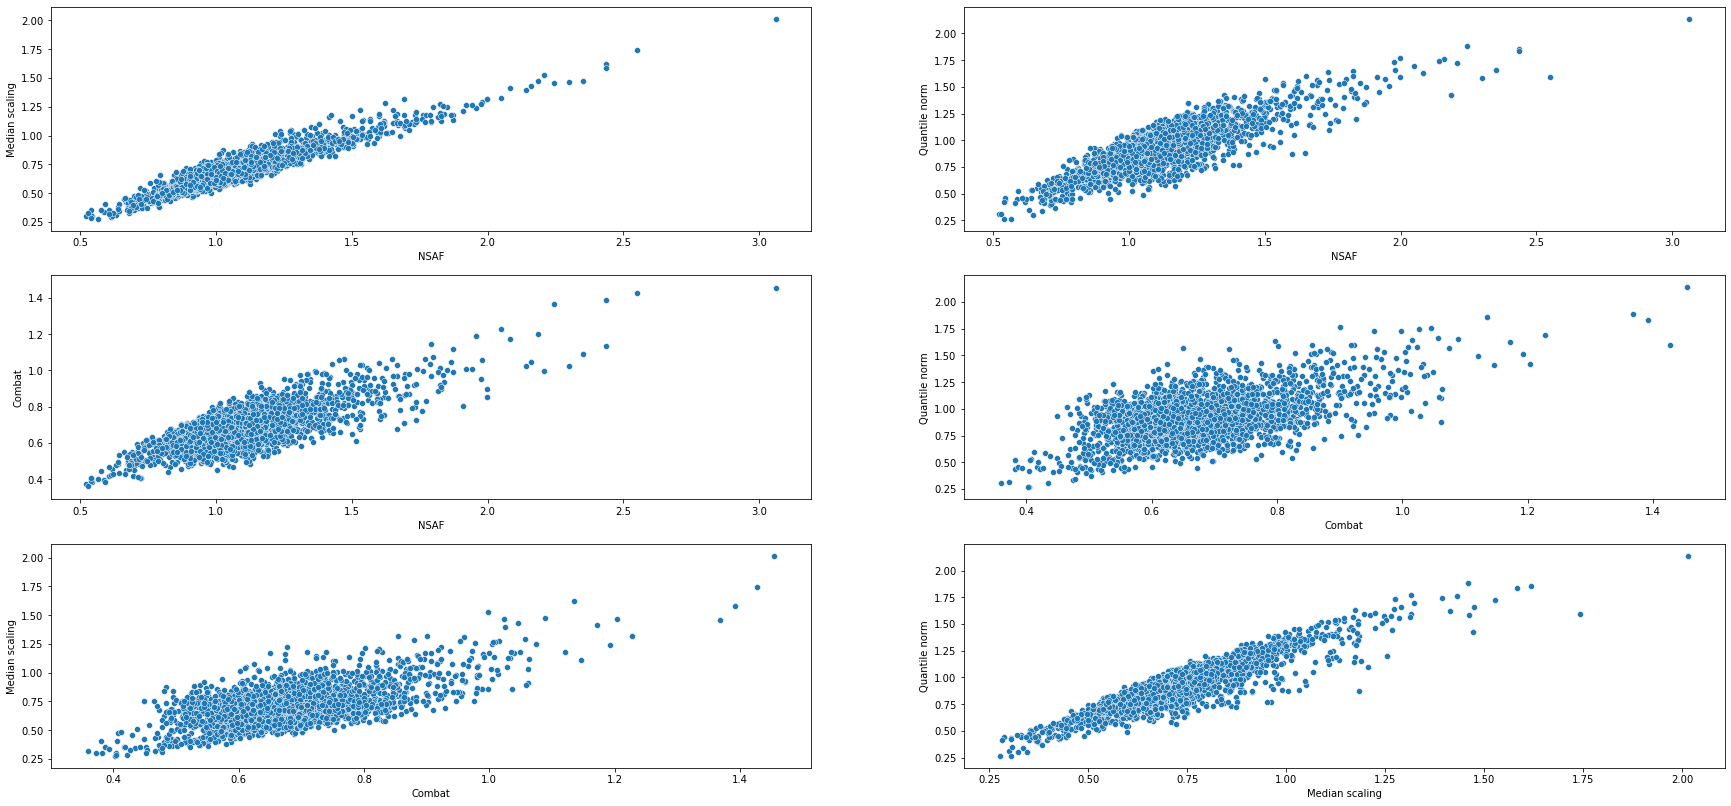

In [188]:
fig, ax = plt.subplots(3,2, figsize=(30,14))

scaled_std = scaled_nsaf.std()
quantile_std = quantile_normalized_df.std()
combat_std = combat_df.std()
nsaf_std = np.log2(nsaf_filtered).std()

ax[0][0].set_ylabel("Median scaling")
ax[1][0].set_ylabel("Combat")
ax[2][0].set_ylabel("Median scaling")

ax[0][0].set_xlabel("NSAF")
ax[1][0].set_xlabel("NSAF")
ax[2][0].set_xlabel("Combat")

ax[0][1].set_ylabel("Quantile norm")
ax[1][1].set_ylabel("Quantile norm")
ax[2][1].set_ylabel("Quantile norm")

ax[0][1].set_xlabel("NSAF")
ax[1][1].set_xlabel("Combat")
ax[2][1].set_xlabel("Median scaling")

sns.scatterplot(x=nsaf_std, y=scaled_std, ax=ax[0][0])
sns.scatterplot(x=nsaf_std, y=combat_std, ax=ax[1][0])
sns.scatterplot(x=combat_std, y=scaled_std, ax=ax[2][0])

sns.scatterplot(x=nsaf_std, y=quantile_std, ax=ax[0][1])
sns.scatterplot(x=combat_std, y=quantile_std, ax=ax[1][1])
sns.scatterplot(x=scaled_std, y=quantile_std, ax=ax[2][1])

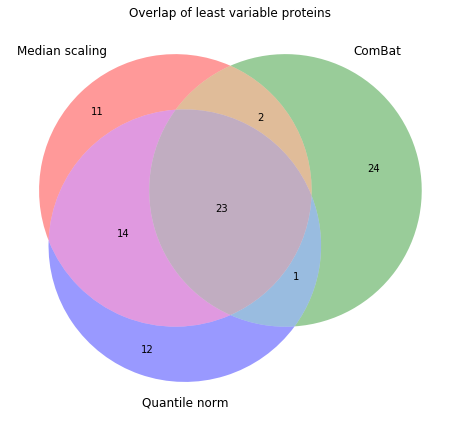

In [198]:
import matplotlib_venn as venn

fig, ax = plt.subplots(1,1, figsize= (8,8), facecolor = "white")
ax.set_title("Overlap of least variable proteins")
venn.venn3([set(lowest_std_med[:50]["uniprot_id"]), set(lowest_std_combat[:50]["index"]), set(lowest_std_quant[:50]["uniprot_id"])], ["Median scaling", "ComBat", "Quantile norm"])

In [195]:
common_least_variable = set(lowest_std_med[:50]["uniprot_id"]).intersection(set(lowest_std_combat[:50]["index"])).intersection(set(lowest_std_quant[:50]["uniprot_id"]))

In [200]:
import mysql.connector

conn = mysql.connector.connect(user='root', password='password', host='127.0.0.1', port='3306',database='expression_atlas_cells')
mycursor = conn.cursor(buffered = True)

# check the connection
if conn.is_connected():
    print("connection succesfull")
else:
    print("no connection")

seqsql = "SELECT protein.uniprot_id, protein.description FROM protein WHERE length IS NOT NULL"
uniprot_description = pd.read_sql_query(seqsql, conn)
uniprot_description.description = uniprot_description.description.apply(lambda x: x.split("(")[0])
uniprot_description = uniprot_description.set_index("uniprot_id")

import json
with open("../ML/GO_F_uniprot_map.json", 'r') as f:
    uniprot_go_function = json.load(f)

GO_description = pd.read_csv("../annotation_files/go_description.txt", sep="\t", index_col="GO_ID")

connection succesfull


In [201]:
uniprot_description.loc[list(common_least_variable)]

description
uniprot_id                                                   
P13639                                   Elongation factor 2 
P53618                                 Coatomer subunit beta 
P49915                  GMP synthase [glutamine-hydrolyzing] 
Q9Y3I0                      RNA-splicing ligase RtcB homolog 
P50990                     T-complex protein 1 subunit theta 
O00231       26S proteasome non-ATPase regulatory subunit 11 
P52907               F-actin-capping protein subunit alpha-1 
Q8WUM4           Programmed cell death 6-interacting protein 
P13010            X-ray repair cross-complementing protein 5 
P54136                    Arginine--tRNA ligase, cytoplasmic 
P23526                                Adenosylhomocysteinase 
Q14152      Eukaryotic translation initiation factor 3 sub...
P42704      Leucine-rich PPR motif-containing protein, mit...
P50991                     T-complex protein 1 subunit delta 
Q7KZF4      Staphylococcal nuclease domain-containing prot...
P07900                       Heat shock protein HSP 90-alpha 
Q9UHB9             Signal recognition particle subunit SRP68 
P55060                                            Exportin-2 
P53396                                  ATP-citrate synthase 
Q99832                       T-complex protein 1 subunit eta 
Q15691      Microtubule-associated protein RP/EB family me...
P12004                    Proliferating cell nuclear antigen 
P49411                   Elongation factor Tu, mitochondrial

In [202]:
GO_low_variable_prot = {}

for i, prot in enumerate(lowest_std.uniprot_id):
    for go in uniprot_go_function[prot]:
        if go not in GO_low_variable_prot.keys():
            GO_low_variable_prot[go] = np.array([1])
        else:
            GO_low_variable_prot[go] += 1
    if i == 9:
        break

mapper = {}
for go in GO_low_variable_prot.keys():
    if go in GO_description.index:
        mapper[go] = GO_description.loc[go].annotation_label

GO_low_variable_prot = pd.DataFrame(data=GO_low_variable_prot)
GO_low_variable_prot.T.rename(index=mapper).sort_values(by=0,ascending=False)[:10]

0
protein binding                          10
RNA binding                               6
ATP binding                               5
ATP hydrolysis activity                   4
ATP-dependent protein folding chaperone   3
ubiquitin protein ligase binding          3
unfolded protein binding                  3
protein folding chaperone                 3
cadherin binding                          2
endonuclease activity                     1

In [203]:
for x in common_least_variable:
    print(x)

P13639
P53618
P49915
Q9Y3I0
P50990
O00231
P52907
Q8WUM4
P13010
P54136
P23526
Q14152
P42704
P50991
Q7KZF4
P07900
Q9UHB9
P55060
P53396
Q99832
Q15691
P12004
P49411


In [186]:
# settings: Minimum required interaction score: .7 (high confidence)
string_results = pd.read_csv("enrichment.all.tsv", sep="\t")

#category     term ID  \
0    GO Process  GO:2000573   
1    GO Process  GO:0032212   
2    GO Process  GO:1904851   
3    GO Process  GO:1904871   
4    GO Process  GO:0016032   
..          ...         ...   
136    InterPro   IPR002423   
137    InterPro   IPR017998   
138    InterPro   IPR027409   
139    InterPro   IPR027410   
140    InterPro   IPR027413   

                                      term description  observed gene count  \
0      Positive regulation of DNA biosynthetic process                    6   
1    Positive regulation of telomere maintenance vi...                    4   
2    Positive regulation of establishment of protei...                    3   
3    Positive regulation of protein localization to...                    3   
4                                        Viral process                    8   
..                                                 ...                  ...   
136                      Chaperonin Cpn60/TCP-1 family                    3   
137   Chaperone tailless complex polypeptide 1 (TCP-1)                    3   
138               GroEL-like apical domain superfamily                    3   
139  TCP-1-like chaperonin intermediate domain supe...                    3   
140           GroEL-like equatorial domain superfamily                    3   

     background gene count  strength  false discovery rate  \
0                       70      1.86              0.000003   
1                       34      2.00              0.000440   
2                       10      2.41              0.000860   
3                       11      2.37              0.000870   
4                      776      0.94              0.000950   
..                     ...       ...                   ...   
136                     15      2.23              0.002100   
137                     10      2.41              0.002100   
138                     15      2.23              0.002100   
139                     15      2.23              0.002100   
140                     14      2.26              0.002100   

               matching proteins in your network (IDs)  \
0    9606.ENSP00000258091,9606.ENSP00000286788,9606...   
1    9606.ENSP00000258091,9606.ENSP00000286788,9606...   
2    9606.ENSP00000258091,9606.ENSP00000286788,9606...   
3    9606.ENSP00000258091,9606.ENSP00000286788,9606...   
4    9606.ENSP00000249923,9606.ENSP00000322439,9606...   
..                                                 ...   
136  9606.ENSP00000258091,9606.ENSP00000286788,9606...   
137  9606.ENSP00000258091,9606.ENSP00000286788,9606...   
138  9606.ENSP00000258091,9606.ENSP00000286788,9606...   
139  9606.ENSP00000258091,9606.ENSP00000286788,9606...   
140  9606.ENSP00000258091,9606.ENSP00000286788,9606...   

            matching proteins in your network (labels)  
0                   CCT7,CCT8,HSP90AA1,PCNA,XRCC5,CCT4  
1                                 CCT7,CCT8,XRCC5,CCT4  
2                                       CCT7,CCT8,CCT4  
3                                       CCT7,CCT8,CCT4  
4    COPB1,TUFM,HSP90AA1,SND1,EIF3A,PCNA,XRCC5,PDCD6IP  
..                                                 ...  
136                                     CCT7,CCT8,CCT4  
137                                     CCT7,CCT8,CCT4  
138                                     CCT7,CCT8,CCT4  
139                                     CCT7,CCT8,CCT4  
140                                     CCT7,CCT8,CCT4  

[141 rows x 9 columns]

# Tau scores

In [260]:
combat_med_per_group = pd.merge(np.exp2(combat_df).reset_index(), meta.Group.reset_index()).set_index("assay_id").groupby("Group").median().T
quantile_med_per_group = pd.merge(np.exp2(quantile_normalized_df).reset_index(), meta.Group.reset_index()).set_index("assay_id").groupby("Group").median().T
nsaf_med_per_group = pd.merge(nsaf_filtered.reset_index(), meta.Group.reset_index()).set_index("assay_id").groupby("Group").median().T

In [213]:
def calc_tau_exp(values, prot):
    max_val = max(values)

    tau = 0
    for i, v in enumerate(values):
        
        tau += (1-(v/max_val))

    val = np.round(tau/i, 2)
    if val > 1:
        return 0
    return val

In [261]:
tau_exp_data_combat = {}
for prot_id, row in combat_med_per_group.iterrows():
    tau_exp_data_combat[prot_id] = calc_tau_exp(row.tolist(), prot_id)

tau_exp_data_quant = {}
for prot_id, row in quantile_med_per_group.iterrows():
    tau_exp_data_quant[prot_id] = calc_tau_exp(row.tolist(), prot_id)

tau_exp_data = {}
for prot_id, row in nsaf_med_per_group.iterrows():
    tau_exp_data[prot_id] = calc_tau_exp(row.tolist(), prot_id)

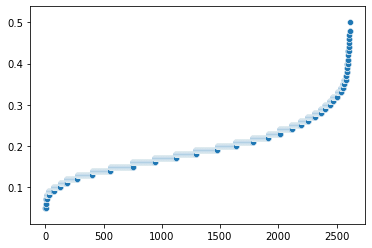

In [220]:
sns.scatterplot(x=range(len(tau_exp_data)), y=np.sort(np.array(list(tau_exp_data.values()))))

In [264]:
tau_vs_std = {}
for x in tau_exp_data.keys():
    tau_vs_std[x] = [tau_exp_data_combat[x], tau_exp_data_quant[x], tau_exp_data[x],combat_std[x], quantile_std[x], nsaf_std[x]]

In [265]:
tau_vs_std = pd.DataFrame(tau_vs_std, index="TauCombat TauQuant TauNSAF ComBat Quantile NSAF".split())

In [266]:
tau_vs_std = tau_vs_std.T

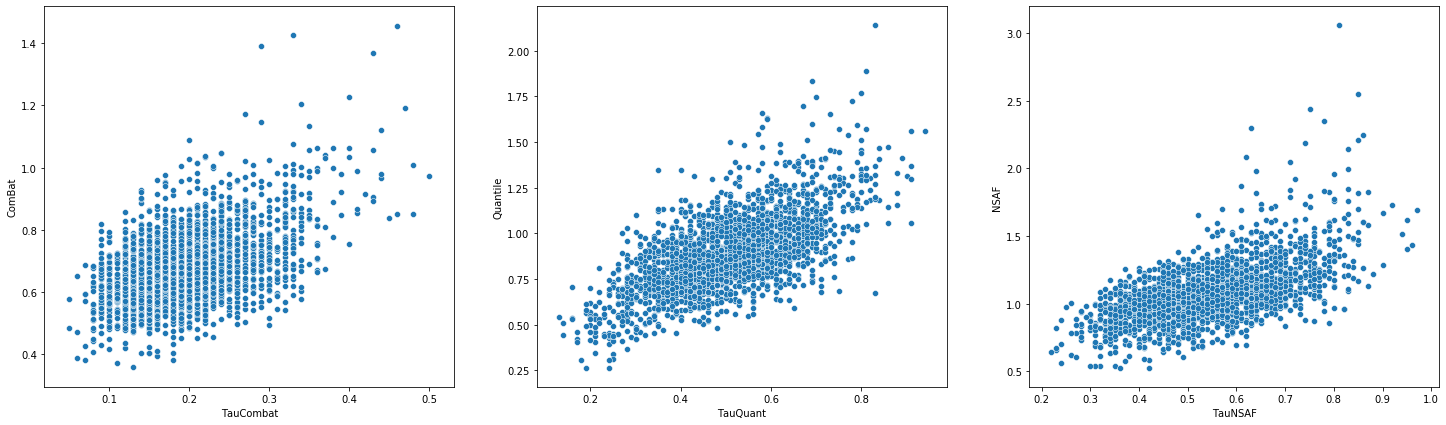

In [267]:
fig, ax = plt.subplots(1,3, figsize=(25,7))
for i,x in enumerate(ax):
    sns.scatterplot(data=tau_vs_std, x="TauCombat TauQuant TauNSAF".split()[i], y="ComBat Quantile NSAF".split()[i], ax=x)

---

In [25]:
test_ids = meta[meta.Group == "HeLa"].index

In [33]:
for i, x in nsaf_filtered.loc[test_ids].iteritems():
    print(i)

A0AVT1
A0MZ66
A0PJW6
A1X283
A2RRP1
A3KMH1
A3KN83
A4D1E9
A5YKK6
A6NDG6
A6NDU8
A6NHL2
A6NHR9
A6NHT5
A6NIH7
A6NJ78
A8MXV4
E9PRG8
L0R6Q1
L0R8F8
O00115
O00148
O00151
O00154
O00170
O00178
O00186
O00203
O00231
O00232
O00264
O00267
O00273
O00291
O00299
O00330
O00391
O00399
O00401
O00411
O00418
O00425
O00429
O00442
O00443
O00461
O00483
O00487
O00499
O00505
O00560
O00566
O00567
O00592
O00625
O00743
O00754
O00767
O14497
O14530
O14545
O14561
O14579
O14617
O14646
O14656
O14657
O14672
O14733
O14745
O14777
O14802
O14818
O14828
O14907
O14908
O14926
O14929
O14949
O14976
O15020
O15031
O15042
O15047
O15066
O15067
O15084
O15085
O15091
O15111
O15116
O15118
O15121
O15127
O15143
O15144
O15145
O15164
O15173
O15212
O15213
O15226
O15228
O15230
O15235
O15254
O15258
O15269
O15270
O15294
O15355
O15371
O15379
O15381
O15397
O15400
O15446
O15460
O15511
O15541
O43143
O43148
O43149
O43150
O43156
O43172
O43181
O43237
O43242
O43252
O43264
O43290
O43324
O43353
O43395
O43402
O43422
O43504
O43583
O43592
O43615
O43660
O43663

In [36]:
running_var = 0
weights = []
for i, x in nsaf_filtered.loc[test_ids].iteritems():
    variance_protein = np.nanvar(x)
    w = np.count_nonzero(np.isnan(x))

    running_var += variance_protein*w
    weights.append(w)

PEV = running_var/sum(weights)
PEV

2.8789362240856856e-08

In [ ]:
# Pooled estimate of variance

# s²p = ((notna protein i in samples -1)*variance proteini  + ... /  (samplesize1 + saplesize2 -2)

def calculate_PEV(dataset, assay_ids):
    
    comp_df = dataset.loc[assay_ids]
    print(comp_df.shape)
    running_var = 0
    weights = []

    for i, x in comp_df.iteritems():
        variance_protein = np.nanvar(x)
        w = np.count_nonzero(np.isnan(x))

        if np.isnan(variance_protein):
            continue
        running_var += variance_protein*w
        weights.append(w)
    print(len(weights))
    PEV = running_var/sum(weights)
    return PEV


def calculate_PEV_bygroup(dataset):
    groups = meta.Group.unique()

    # Calculate PEV for each Group where the subgroups are defined by project
    PEV_by_group = {}
    for group in groups:
        assay_ids = meta[meta.Group == group].index
        PEV = calculate_PEV(dataset, assay_ids)
        PEV_by_group[group] = PEV

    return PEV_by_group

In [ ]:
PEV_nsaf = calculate_PEV_bygroup(np.log2(nsaf_filtered))
PEV_scaled = calculate_PEV_bygroup(scaled_nsaf)
PEV_quant = calculate_PEV_bygroup(quantile_normalized_df)
PEV_combat = calculate_PEV_bygroup(combat_df)

(13, 2615)


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Degrees of freedom <= 0 for slice.
  del sys.path[0]


(48, 2615)
(26, 2615)
(15, 2615)
(100, 2615)
(10, 2615)
(24, 2615)
(78, 2615)
(23, 2615)
(24, 2615)
(26, 2615)
(60, 2615)
(19, 2615)
(10, 2615)
(42, 2615)
(13, 2615)
(48, 2615)
(26, 2615)
(15, 2615)
(100, 2615)
(10, 2615)
(24, 2615)
(78, 2615)
(23, 2615)
(24, 2615)
(26, 2615)
(60, 2615)
(19, 2615)
(10, 2615)
(42, 2615)
(13, 2615)
(48, 2615)
(26, 2615)
(15, 2615)
(100, 2615)
(10, 2615)
(24, 2615)
(78, 2615)
(23, 2615)
(24, 2615)
(26, 2615)
(60, 2615)
(19, 2615)
(10, 2615)
(42, 2615)
(13, 2615)


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


(48, 2615)
(26, 2615)
(15, 2615)
(100, 2615)
(10, 2615)
(24, 2615)
(78, 2615)
(23, 2615)
(24, 2615)
(26, 2615)
(60, 2615)
(19, 2615)
(10, 2615)
(42, 2615)


In [47]:
df_PEV = {}
for key in PEV_nsaf.keys():
    df_PEV[key] = [PEV_nsaf[key], PEV_scaled[key], PEV_quant[key], PEV_combat[key]]

In [48]:
df_PEV_ = pd.DataFrame(df_PEV, columns="NSAF med_scaled Quantile ComBat".split())

In [50]:
df_PEV_.melt()

Empty DataFrame
Columns: [variable, value]
Index: []

In [49]:
sns.barplot(df_PEV_.melt(), x="value", hue="variable")

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


ValueError: Could not interpret input 'variable'